<a href="https://colab.research.google.com/github/ThanosApostolou/aics-pattern-recognition/blob/main/%CE%91%CE%BD%CF%84%CE%AF%CE%B3%CF%81%CE%B1%CF%86%CE%BF_IMDB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<a href="https://colab.research.google.com/github/ThanosApostolou/aics-pattern-recognition/blob/main/IMDB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# INSTALL DEPENDENCIES
# Uncomment and run only once.
%pip install matplotlib numpy pandas scikit-learn scipy tensorflow pyclustering

Note: you may need to restart the kernel to use updated packages.


In [2]:
# IMPORTS AND GLOBAL CONSTANTS

# Load the TensorBoard notebook extension
%load_ext tensorboard

import math
import tensorflow as tf
import datetime, os
import numpy as np 
import pandas as pd
import os
import matplotlib.pyplot as plt
import typing
import numpy.typing as np_typing
from sklearn.model_selection import train_test_split
##MAIN PROGRAM VARIABLES##
##(0): dataset: np array of strings
##(1): dataframe: original dataset in its primal form
##(2): ratings_num_df: new dataframe storing the number of rated items per unique user
##(3): ratings_span_df: new dataframe storing the timespan in days for each user
##(4): minimum_ratings - maximum_ratings => ratings_df=> (i) final_df

# Constants
DATASET_FILE_PATH = "./Dataset.npy"
#Define the figures path
# FIGURES_PATH = "figures"
# os.makedirs(FIGURES_PATH, exist_ok=True)
# #Define the data folder path
DATAFOLDER_PATH = "datafiles"
os.makedirs(DATAFOLDER_PATH, exist_ok=True)
RESULTS_PATH = "results"
os.makedirs(RESULTS_PATH, exist_ok=True)


L_CLUSTERS_NUM = 5
K_NEIGHBORS_NUM = 6

if 'google.colab' in str(get_ipython()):
  print('Running on CoLab')
  from google.colab import drive
  drive.mount('/content/drive/')
  DATASET_FILE_PATH = "/content/drive/My Drive/Colab Notebooks/Dataset.npy"


2023-04-05 16:30:54.425344: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-04-05 16:30:54.448721: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-04-05 16:30:54.449446: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-05 16:30:55.268997: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


'dataset.size'

4669820

'INITIAL DATASET: 1499238 number of unique users and 351109 of unique movies'

'INITIAL DATASET: 4669820 total number of existing ratings'

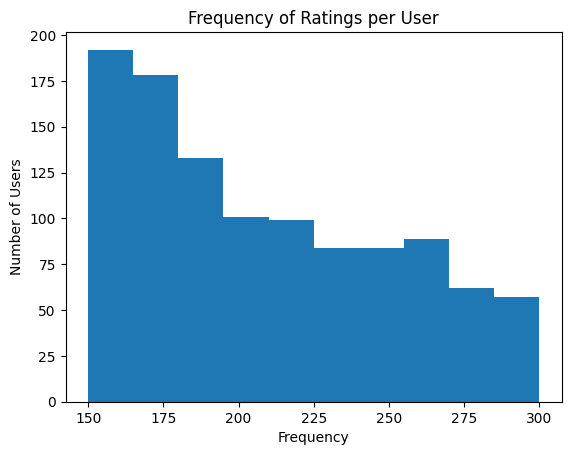

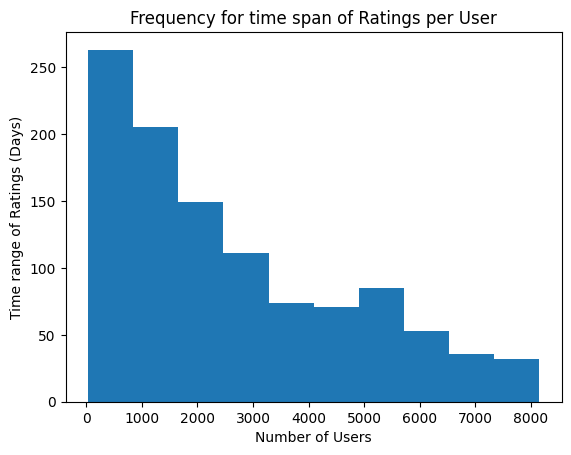

'REDUCED DATASET: 1079 number of unique users and 68084 number of unique movies'

'REDUCED DATASET: 224704 number of existing ratings in the dataset'

'ratings_matrix_df'

Movie,0,1,2,3,4,5,6,7,8,9,...,68074,68075,68076,68077,68078,68079,68080,68081,68082,68083
User,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1074,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1075,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1076,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


'ratings_matrix_array'

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

'W'

array([[1.        , 0.01627907, 0.00228311, ..., 0.00228311, 0.0017331 ,
        0.00998004],
       [0.01627907, 1.        , 0.00657895, ..., 0.00657895, 0.        ,
        0.        ],
       [0.00228311, 0.00657895, 1.        , ..., 0.        , 0.01360544,
        0.        ],
       ...,
       [0.00228311, 0.00657895, 0.        , ..., 1.        , 0.00224215,
        0.0026738 ],
       [0.0017331 , 0.        , 0.01360544, ..., 0.00224215, 1.        ,
        0.        ],
       [0.00998004, 0.        , 0.        , ..., 0.0026738 , 0.        ,
        1.        ]])

'CommonRatings'

array([[285.,   7.,   1., ...,   1.,   1.,   5.],
       [  7., 152.,   2., ...,   2.,   0.,   0.],
       [  1.,   2., 154., ...,   0.,   6.,   0.],
       ...,
       [  1.,   2.,   0., ..., 154.,   1.,   1.],
       [  1.,   0.,   6., ...,   1., 293.,   0.],
       [  5.,   0.,   0., ...,   1.,   0., 221.]])

'ratings_matrix_df'

Movie,0,1,2,3,4,5,6,7,8,9,...,68074,68075,68076,68077,68078,68079,68080,68081,68082,68083
User,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1074,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1075,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1076,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


'ratings_matrix_array'

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [3]:
def calculate_ratings_matrix_df_W_CommonRatings():
    dataset: np.ndarray = np.load(DATASET_FILE_PATH)
    display('dataset.size', dataset.size)
    
    #### CELL 1
    #Define the splitter lambda function in order to tokenize the initial string data.
    splitter = lambda s: s.split(",")
    #Apply the splitter lambda function on the string np array
    dataset = np.array([splitter(x) for x in dataset])
    #Set the pickle file for storing the initial dataframe
    pickle_file = os.path.join(DATAFOLDER_PATH, "dataframe.pkl")
    #Check the existence of the specified file.
    if os.path.exists(pickle_file):
        #Load the pickle file
        dataframe = pd.read_pickle(pickle_file)
    else:
        #Create the dataframe object.
        dataframe = pd.DataFrame(dataset, columns=['User','Movie','Rating','Date'])
        #Convert the string elements of the "Users" series into integers
        dataframe["User"] = dataframe["User"].apply(lambda s:np.int64(s.replace("ur","")))
        #Convert the string elements of the "Movies" series into integers
        dataframe["Movie"] = dataframe["Movie"].apply(lambda s:np.int64(s.replace("tt","")))
        #Convert the string elements of the "Ratings" series into integers
        dataframe["Rating"] = dataframe["Rating"].apply(lambda s:np.int64(s))
        #Convert the string element of "Dates" series into datetime Object
        dataframe["Date"] = pd.to_datetime(dataframe["Date"])
        dataframe.to_pickle(pickle_file)
    

    #### CELL 2
    #Get the unique users in the dataset.
    users = dataframe["User"].unique()
    #Get the number of unique users
    users_num = len(users)
    #Get the unique movie items in the dataset.
    movies = dataframe["Movie"].unique()
    #Get the number of unique movies
    movies_num = len(movies)
    #Get the total number of existing ratings.
    ratings_num = dataframe.shape[0]
    #Report the number of unique Users and Movies in the dataset
    display("INITIAL DATASET: {0} number of unique users and {1} of unique movies".format(users_num, movies_num))
    #Report the total number of existing ratings in the dataset
    display("INITIAL DATASET: {} total number of existing ratings".format(ratings_num))



    # CELL 3
    #Define the pickle file that will store the time span per user dataframe
    pickle_file = os.path.join(DATAFOLDER_PATH, "ratings_num_df.pkl")
    #Check the existence of the previously defined pickle file
    if os.path.exists(pickle_file):
        #Load the pickle file
        ratings_num_df = pd.read_pickle(pickle_file)
    else:
        ratings_num_df = dataframe.groupby("User")["Rating"].count().sort_values(ascending=False).reset_index(name="ratings_num")
        #Save the previously created dataframe to pickle
        ratings_num_df.to_pickle(pickle_file)
    


    # CELL 4
    #Set the pickle file that will store the time span per user dataframe
    pickle_file = os.path.join(DATAFOLDER_PATH, "ratings_span_df.pkl")
    if os.path.exists(pickle_file):
        ratings_span_df = pd.read_pickle(pickle_file)
    else:
        ratings_span_df = dataframe.groupby("User")["Date"].apply(lambda date: max(date)-min(date)).sort_values(ascending=False).reset_index(name="ratings_span")
        ratings_span_df.to_pickle(pickle_file)
    #Create a new ratings dataframe by joining the previously defined dataframe
    ratings_df = ratings_num_df.join(ratings_span_df.set_index("User"),on="User")
    ratings_df["ratings_span"]=ratings_df["ratings_span"].dt.days
    #Set the threshold values for the minimum and maximum number of Ratings per user
    minimum_ratings = 150
    maximum_ratings = 300
    #Discard all users that do not pertain to the previous range of ratings
    reduced_ratings_df = ratings_df.loc[(ratings_df["ratings_num"] >= minimum_ratings) & (ratings_df["ratings_num"] <= maximum_ratings)]

    #Generate the frequency histogram for the number of ratings per user
    reduced_ratings_df["ratings_num"].plot(kind='hist', title='Frequency of Ratings per User', xticks=range(minimum_ratings, maximum_ratings+1, 25))
    plt.xlabel('Frequency')
    plt.ylabel('Number of Users')

    plt.show()
    #Generate the frequency histogram for the time span of ratings per user
    reduced_ratings_df["ratings_span"].plot(kind='hist', title='Frequency for time span of Ratings per User')
    plt.xlabel('Number of Users')
    plt.ylabel('Time range of Ratings (Days)')

    plt.show()



    #### CELL 5
    #Get the final dataframe by excluding all users whose ratings fall outside the prespecified range
    final_df = dataframe.loc[dataframe["User"].isin(reduced_ratings_df["User"])].reset_index()
    #Drop the links (indices) to the original table
    final_df = final_df.drop("index", axis=1)
    #Get the unique users and items in the final dataframe along with the final number of ratings
    final_users = final_df["User"].unique()
    final_movies = final_df["Movie"].unique()
    final_users_num = len(final_users)
    final_movies_num = len(final_movies)
    final_ratings_num = len(final_df)

    #Report the final number of unique users and movies in the dataset
    display("REDUCED DATASET: {0} number of unique users and {1} number of unique movies".format(final_users_num, final_movies_num))
    #Report the final number of existing ratings in the dataset
    display("REDUCED DATASET: {} number of existing ratings in the dataset".format(final_ratings_num))



    # CELL 6
    #We need to reset the users and items IDs in order to be able to construct a network of users and Movies. 
    #Users and Movies IDs should be consecutive in the [1..final_users_num] and [1...final_movies_num]
    #Initially, we need to acquire the sorted versions of the user and movies
    sorted_final_users = np.sort(final_users)
    sorted_final_movies = np.sort(final_movies)
    #Generate the dictionary of final users as a mapping of the following 
    #sorted_final_users --> [0...final_users_num-1]
    final_users_dict = dict(zip(sorted_final_users,list(range(0,final_users_num))))
    #Generate the dictionary of final items as a mapping of the following
    final_movies_dict = dict(zip(sorted_final_movies,list(range(0,final_movies_num))))
    #Apply the previously defined dictionary-based maps on the users and movies columns of the final dataframe
    final_df["User"] = final_df["User"].map(final_users_dict)
    final_df["Movie"] = final_df["Movie"].map(final_movies_dict)
    #Get a grouped version of the original dataframe based on the unique final users
    users_group_df = final_df.groupby("User")
    #Initialize the adjacency matrix which stores the connection status for pair of users in the recommendation network
    W = np.zeros((final_users_num, final_users_num))
    #Iinitialize the matrix storing the number of commonly rated items for a pair of users
    CommonRatings = np.zeros((final_users_num, final_users_num))
    #Initialize the matrix of common ratings
    #Matrix W will be of size [final_users_num x final_users_num],
    #Let U = {u1, u2,...,un} be the final set of users and I = {i1,i2,...,im}
    #final set of movies. By considering the function Fi: U -> P(I) where
    #P(I) is the powerset of I, Fi(u) returns the subset of items that has been rated by user u. 
    #In this context, the edge weight between any given pair of users (u,v) will be computed as:
    #
    #          |Intersection(Fi(u)),Fi(v))|
    #W(u,v) =  -----------------------------
    #               |Union(Fi(u),Fi(v))|
    #
    #
    #In order to speed up the construction of the adjacency matrix for the ratings network, 
    #construct a dictionary object that will store a set of rated items for each unique user.
    user_items_dict = {}
    # for user in final_users:
        #print(user)
        # user_index = final_users_dict[user]
        # user_movies = set(users_group_df.get_group(user_index)["Movie"])
        # user_items_dict[user_index] = user_movies
                                                    
    # Initialize the dictionary for storing the set of rated items for each user
    user_items_dict = {}
    # print(final_users_dict)
    # print(sorted_final_users)
    # print(final_users_dict)
    # For each unique user, find the set of movies that they rated
    for user in final_users:
        if user in final_users_dict:
            user_index = final_users_dict[user]
            user_movies = set(users_group_df.get_group(user_index)["Movie"])
            user_items_dict[user_index] = user_movies 
    


    #### CELL 7
    user_ids = list(user_items_dict.keys())
    user_ids.sort()
    #Generate the sorted version of the dictionary
    user_items_dict = {user_index:user_items_dict[user_index] for user_index in user_ids}
    #Set the pickle file that will store the graph adjacency matrix W.
    pickle_file_weights = os.path.join(DATAFOLDER_PATH, "w.npy")
    pickle_file_common_ratings = os.path.join(DATAFOLDER_PATH, "common_ratings.npy")
    #Check the existence of the previously defined pickle file
    if os.path.exists(pickle_file_weights) & os.path.exists(pickle_file_common_ratings):
        #Load the pickle file
        W = np.load(pickle_file_weights)
        CommonRatings = np.load(pickle_file_common_ratings)
    else:
        for source_user in user_items_dict.keys():
            for target_user in user_items_dict.keys():
                intersection_items = user_items_dict[source_user].intersection(user_items_dict[target_user])
                union_items = user_items_dict[source_user].union(user_items_dict[target_user])
                W[source_user, target_user] = len(intersection_items)/len(union_items)
                CommonRatings[source_user, target_user] = len(intersection_items)
        np.save(pickle_file_weights,W)
        np.save(pickle_file_common_ratings,CommonRatings)

    

    # Create a pivot table of user-movie ratings
    ratings_matrix_df = final_df.pivot_table(index='User', columns='Movie', values='Rating')
    ratings_matrix_df = ratings_matrix_df.fillna(0)

    ratings_matrix_array = ratings_matrix_df.to_numpy()

    display('ratings_matrix_df', ratings_matrix_df)
    display('ratings_matrix_array', ratings_matrix_array)

    #### OUTPUT
    return ratings_matrix_df, W, CommonRatings


ratings_matrix_df, W, CommonRatings = calculate_ratings_matrix_df_W_CommonRatings()
ratings_matrix_array = ratings_matrix_df.to_numpy()
display('W', W)
display('CommonRatings', CommonRatings)
display('ratings_matrix_df', ratings_matrix_df)
display('ratings_matrix_array', ratings_matrix_array)

#Δημιουργούμε έναν πίνακα χρηστών - ταινιών 
(οι χρήστες βρίσκονται στις γραμμές και οι ταινίες στις στήλες του πίνακα)
όπου τα στοιχεία του πίνακα είναι από 1 - 10. Εάν ο χρήστης δεν έχει αξιολογήσει την ταινία,
η αξιολόγηση που θα ανατεθεί είναι 0.

In [4]:
from pyclustering.cluster.kmeans import kmeans, kmeans_visualizer
from pyclustering.cluster.center_initializer import kmeans_plusplus_initializer
from pyclustering.samples.definitions import FCPS_SAMPLES
from pyclustering.utils import read_sample
from pyclustering.cluster.kmeans import kmeans
from pyclustering.utils.metric import type_metric, distance_metric

Θέλουμε να δημιουργήσουμε τον πίνακα βαρών "λ" των χρηστών. Τον πίνακα αξιολογήσεων δηλαδή όπου η τιμή της αξιολόγησης είναι 1 εάν η ταινία έχει αξιολογηθεί από τον χρήστη ή 0 εάν δεν έχει αξιολογηθεί

In [5]:
# Threshold
threshold = 1

# Transform to binary
binary_matrix = np.where(ratings_matrix_df >= threshold, 1, 0)
display('binary_matrix', binary_matrix)

'binary_matrix'

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [6]:
# Convert the matrix to a numpy array

# Create a dictionary that maps each row of the matrix to its index
# matrix_dict = {tuple(row): i for i, row in enumerate(matrix_array)}

# ***Αλγόριθμοι Ομαδοποίησης Δεδομένων***

**Χρήση της Weighted Euclidean Distance**

In [7]:
from scipy.spatial.distance import pdist, cdist
import numpy as np

from scipy.sparse import csr_matrix

def pairwise_weighted_euclidean_distance(X, weights):
    # Find the indices of the rated movies for each pair of users
    rated_movies = (weights_sparse.T @ weights_sparse) > 0

    # Select only the rated movies for each pair of users
    X_rated = X_sparse[:, rated_movies]
    
    # Calculate the pairwise weighted Euclidean distance between 
    #users who have rated the same movie
    return cdist(X, metric='euclidean')

def kmeans_pairwise_weighted_euclidean(X, weights, k, max_iters=2):

    n, m = X.shape
    centroids = X[np.random.choice(n, k, replace=False)]
    distances = pairwise_weighted_euclidean_distance(X, weights)
    for i in range(max_iters):
        # Assign points to clusters
        cluster_assignments = np.argmin(distances, axis=1)

        # Recalculate cluster centroids
        for j in range(k):
            cluster_points = X[cluster_assignments == j]
            if len(cluster_points) > 0:
                centroids[j] = np.average(cluster_points, axis=0)

        # Update distances to centroids
        distances = pairwise_weighted_euclidean_distance(X, weights)

    return cluster_assignments, centroids


# Clustering users using K-means
 We want to start by creating the symmetric D matrix which contains the pairwise weighted Euclidean distance for every pair of users.
 We calculate the distance between each user using 
*   dist_{u,v}=\sum_{k=1}^{n}\sqrt{|R_{u}(k) - R_{v}(k)|λ_{u}(k)λ_{v}(k)}




In [8]:
# Calculate the pairwise weighted Euclidean distance matrix

def create_euclidean_distance_matrix_cached(ratings_matrix: pd.DataFrame, binary_matrix: np_typing.NDArray) -> np_typing.NDArray[np.float64]:
    #Set the npy file that will store the Euclidean distance matrix
    npy_file = os.path.join(DATAFOLDER_PATH, "euclidean_distance_matrix.npy")
    if os.path.exists(npy_file):
        Dist_euclidean: np_typing.NDArray[np.float64] = np.load(npy_file, allow_pickle=True)
        return Dist_euclidean
    else:
        n = ratings_matrix.shape[0]
        Dist_euclidean = np.zeros((n, n))
        for i in range(n):
            for j in range(i, n):
                d = np.sqrt(np.sum(binary_matrix[i,:]*binary_matrix[j,:] * (ratings_matrix.iloc[i,:] - ratings_matrix.iloc[j,:])**2))
                Dist_euclidean[i,j] = d
                Dist_euclidean[j,i] = d
        np.save(npy_file, Dist_euclidean, allow_pickle=True, fix_imports=True)
        return Dist_euclidean


Dist_euclidean = create_euclidean_distance_matrix_cached(ratings_matrix_df, binary_matrix)
Dist_euclidean

array([[0.        , 3.46410162, 1.        , ..., 4.        , 4.        ,
        3.31662479],
       [3.46410162, 0.        , 7.07106781, ..., 5.        , 0.        ,
        0.        ],
       [1.        , 7.07106781, 0.        , ..., 0.        , 8.06225775,
        0.        ],
       ...,
       [4.        , 5.        , 0.        , ..., 0.        , 1.        ,
        0.        ],
       [4.        , 0.        , 8.06225775, ..., 1.        , 0.        ,
        0.        ],
       [3.31662479, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [9]:
df_euclidean = pd.DataFrame(Dist_euclidean)
df_euclidean

,0,1,2,3,4,5,6,7,8,9,...,1069,1070,1071,1072,1073,1074,1075,1076,1077,1078
0,0.000000,3.464102,1.000000,3.872983,9.000000,0.000000,7.141428,0.000000,4.00000,3.872983,...,4.358899,0.0,10.440307,1.000000,1.000000,0.000000,1.000000,4.000000,4.000000,3.316625
1,3.464102,0.000000,7.071068,2.236068,2.449490,7.874008,6.000000,3.316625,1.00000,2.828427,...,3.316625,0.0,9.433981,0.000000,5.291503,3.000000,2.828427,5.000000,0.000000,0.000000
2,1.000000,7.071068,0.000000,13.266499,6.164414,17.549929,6.082763,4.898979,1.00000,9.949874,...,3.464102,0.0,5.656854,1.414214,3.162278,4.242641,5.196152,0.000000,8.062258,0.000000
3,3.872983,2.236068,13.266499,0.000000,10.099505,9.486833,4.898979,7.810250,4.00000,3.162278,...,5.000000,0.0,0.000000,6.708204,0.000000,1.000000,9.000000,0.000000,2.000000,0.000000
4,9.000000,2.449490,6.164414,10.099505,0.000000,9.219544,5.830952,4.358899,2.44949,10.908712,...,9.746794,0.0,9.110434,5.099020,4.690416,0.000000,2.449490,0.000000,6.324555,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1074,0.000000,3.000000,4.242641,1.000000,0.000000,5.000000,1.000000,0.000000,0.00000,0.000000,...,5.099020,0.0,8.717798,2.000000,2.236068,0.000000,5.567764,4.242641,2.000000,0.000000
1075,1.000000,2.828427,5.196152,9.000000,2.449490,9.433981,3.000000,4.242641,1.00000,8.774964,...,7.280110,0.0,6.633250,3.162278,7.071068,5.567764,0.000000,0.000000,7.141428,0.000000
1076,4.000000,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.00000,3.000000,...,7.280110,0.0,0.000000,0.000000,7.483315,4.242641,0.000000,0.000000,1.000000,0.000000
1077,4.000000,0.000000,8.062258,2.000000,6.324555,3.000000,0.000000,0.000000,0.00000,6.164414,...,1.000000,0.0,7.348469,0.000000,0.000000,2.000000,7.141428,1.000000,0.000000,0.000000


Στον πίνακα αποστάσεων που έχουμε δημιουργήσει, θα τρέξουμε τον αλγόριθμο k-means ώστε να αποτιμήσουμε την ομοιότητα των χρηστών χρησιμοποιώντας τις μεταξύ τους αποστάσεις.

In [10]:
from sklearn.cluster import KMeans
# Cluster the users using K-means
kmeans = KMeans(n_clusters=L_CLUSTERS_NUM).fit(Dist_euclidean)

# Get the cluster labels
labels_euclidean = kmeans.labels_

# Print the labels
print(labels_euclidean)

/home/thanos/.pyenv/versions/3.11.2/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[4 4 1 ... 0 3 3]


Cluster the users, by using a custom 
dist = 1 - np.abs(np.sum(R_u*R_v*weights_u*weights_l)/(np.sqrt(R^2_u*weights_u*weights_l)*np.sqrt(R^2_v*weights_u*weights_l)

---



In [11]:
# Calculate the pairwise weighted Cosine distance matrix

def create_cosine_distance_matrix_cached(ratings_matrix: pd.DataFrame, binary_matrix: np_typing.NDArray) -> np_typing.NDArray[np.float64]:
    #Set the npy file that will store the Euclidean distance matrix
    npy_file = os.path.join(DATAFOLDER_PATH, "cosine_distance_matrix.npy")
    if os.path.exists(npy_file):
        Dist_cosine: np_typing.NDArray[np.float64] = np.load(npy_file, allow_pickle=True)
        return Dist_cosine
    else:
        n = ratings_matrix.shape[0]
        Dist_cosine = np.zeros((n, n))
        for i in range(n):
            for j in range(i, n):
                d = 1 - np.abs(np.sum(binary_matrix[i,:] * binary_matrix[j,:] * ratings_matrix.loc[i,:] * ratings_matrix.loc[j,:]) / (np.sqrt(np.sum(binary_matrix[i,:] * binary_matrix[j,:] * ratings_matrix.loc[i,:])* np.sqrt(np.sum(binary_matrix[i,:] * binary_matrix[j,:] * ratings_matrix.loc[j,:])))))
                Dist_cosine[i,j] = d
                Dist_cosine[j,i] = d
        np.save(npy_file, Dist_cosine, allow_pickle=True, fix_imports=True)
        return Dist_cosine


Dist_cosine = create_cosine_distance_matrix_cached(ratings_matrix_df, binary_matrix)
Dist_cosine

array([[-49.30456003, -23.17131563,  -9.14290733, ..., -11.12309303,
         -3.11953429, -19.04920121],
       [-23.17131563, -45.58860287, -10.2468265 , ...,  -7.57549446,
                 nan,          nan],
       [ -9.14290733, -10.2468265 , -51.41799301, ...,          nan,
        -20.34260859,          nan],
       ...,
       [-11.12309303,  -7.57549446,          nan, ..., -23.57674869,
         -9.54142092, -16.7827941 ],
       [ -3.11953429,          nan, -20.34260859, ...,  -9.54142092,
        -48.16458253,          nan],
       [-19.04920121,          nan,          nan, ..., -16.7827941 ,
                 nan, -45.99597475]])

In [12]:
df_cosine = pd.DataFrame(Dist_cosine)
df_cosine = df_cosine.replace(np.nan, 0)
df_cosine

,0,1,2,3,4,5,6,7,8,9,...,1069,1070,1071,1072,1073,1074,1075,1076,1077,1078
0,-49.304560,-23.171316,-9.142907,-18.187750,-15.393314,0.000000,-16.441067,0.000000,-10.618950,-15.466178,...,-26.560915,0.0,-7.324450,-13.696938,-17.348706,0.000000,-15.744288,-11.123093,-3.119534,-19.049201
1,-23.171316,-45.588603,-10.246827,-15.527989,-21.414019,-11.470574,-19.850920,-16.154845,-13.270485,-10.767502,...,-20.238437,0.0,-4.659453,0.000000,-23.888141,-8.457416,-22.252625,-7.575494,0.000000,0.000000
2,-9.142907,-10.246827,-51.417993,-15.439397,-21.888741,-4.886134,-11.812998,-24.434338,-18.417969,-10.573472,...,-25.383218,0.0,-23.526442,-17.983240,-18.300902,-12.677042,-22.851036,0.000000,-20.342609,0.000000
3,-18.187750,-15.527989,-15.439397,-29.955234,-16.635486,-5.198522,-9.686401,-11.153215,-8.513657,-4.000000,...,-13.638128,0.0,-7.891397,-13.683430,0.000000,-9.541421,-16.316961,0.000000,-5.928203,0.000000
4,-15.393314,-21.414019,-21.888741,-16.635486,-54.692987,-10.648180,-21.480240,-23.180685,-24.333153,-17.758224,...,-25.537094,0.0,-17.196210,-17.278876,-21.354134,0.000000,-22.237900,0.000000,-11.975146,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1074,0.000000,-8.457416,-12.677042,-9.541421,0.000000,-2.833659,-5.687403,0.000000,0.000000,-6.476744,...,-13.739990,0.0,-19.779263,-7.846603,-16.308624,-36.384010,-20.927309,-4.879836,-10.785113,0.000000
1075,-15.744288,-22.252625,-22.851036,-16.316961,-22.237900,-13.830095,-10.541441,-18.857696,-11.172184,-13.445036,...,-23.920871,0.0,-20.291674,-12.053884,-26.317221,-20.927309,-50.077889,-15.721563,-23.252681,-16.797114
1076,-11.123093,-7.575494,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-3.000000,-12.156527,...,-15.029568,0.0,0.000000,0.000000,-13.377917,-4.879836,-15.721563,-23.576749,-9.541421,-16.782794
1077,-3.119534,0.000000,-20.342609,-5.928203,-11.975146,-1.828427,0.000000,0.000000,0.000000,-11.116020,...,-18.219691,0.0,-11.425367,-12.454343,0.000000,-10.785113,-23.252681,-9.541421,-48.164583,0.000000


Στον πίνακα αποστάσεων που έχουμε δημιουργήσει, θα τρέξουμε τον αλγόριθμο k-means ώστε να αποτιμήσουμε την ομοιότητα των χρηστών χρησιμοποιώντας τις μεταξύ τους αποστάσεις.

In [13]:
# Cluster the users using K-means
kmeans = KMeans(n_clusters=L_CLUSTERS_NUM).fit(df_cosine)

# Get the cluster labels
labels_cosine = kmeans.labels_

# Print the labels
print(labels_cosine)


/home/thanos/.pyenv/versions/3.11.2/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[3 3 4 ... 0 2 2]


# Elbow Method
Χρησιμοποιούμε την elbow method ώστε να επιλέξουμε τον βέλτιστο αριθμό clusters στον οποίο θα διαχωριστούν τα δεδομένα χρησιμοποιώντας τον k-means

In [14]:
def elbow_method(df: pd.DataFrame, max_iter: int):
  distortions = []
  K = range(1,max_iter)
  for k in K:
    kmeanModel = KMeans(n_clusters=k, n_init=10)
    kmeanModel.fit(df)
    distortions.append(kmeanModel.inertia_)
  plt.figure(figsize=(16,8))
  plt.plot(K, distortions, 'bx-')
  plt.xlabel('k')
  plt.ylabel('Distortion')
  plt.title('The Elbow Method showing the optimal k')
  plt.show()


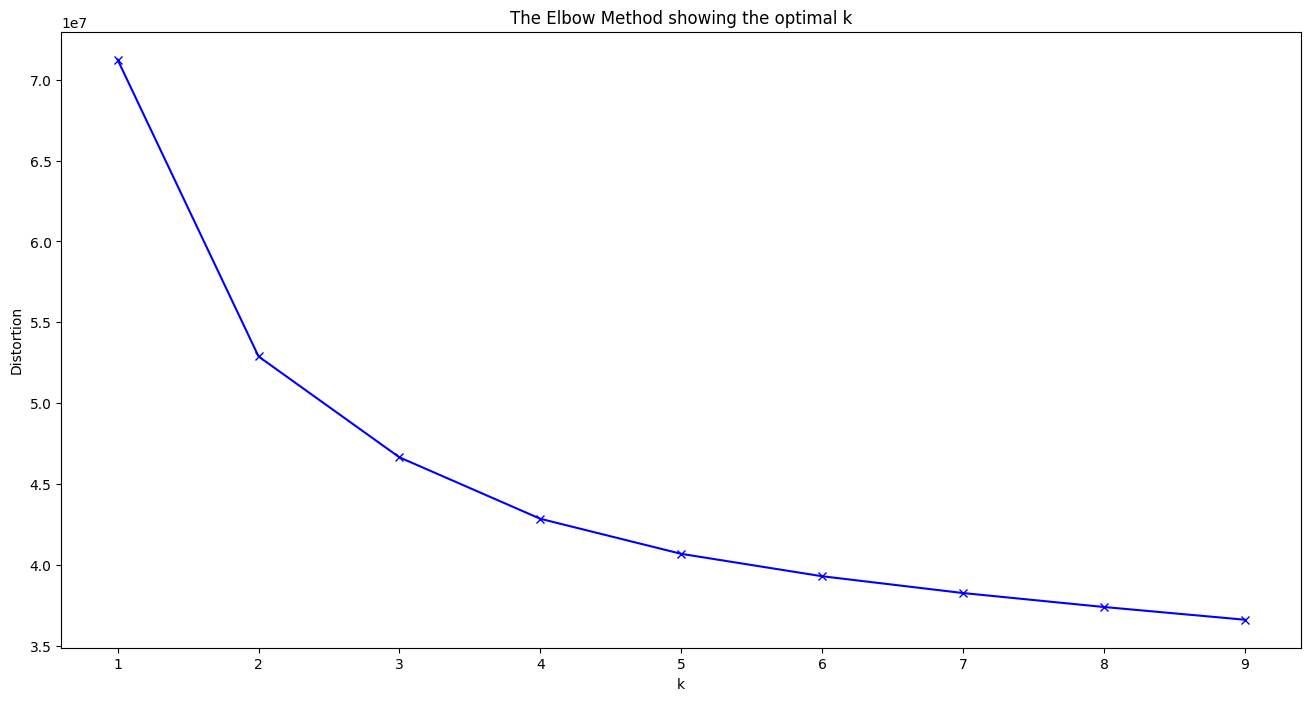

In [15]:
#Using the elbow method on Cosine distance
elbow_method(df_cosine, 10)

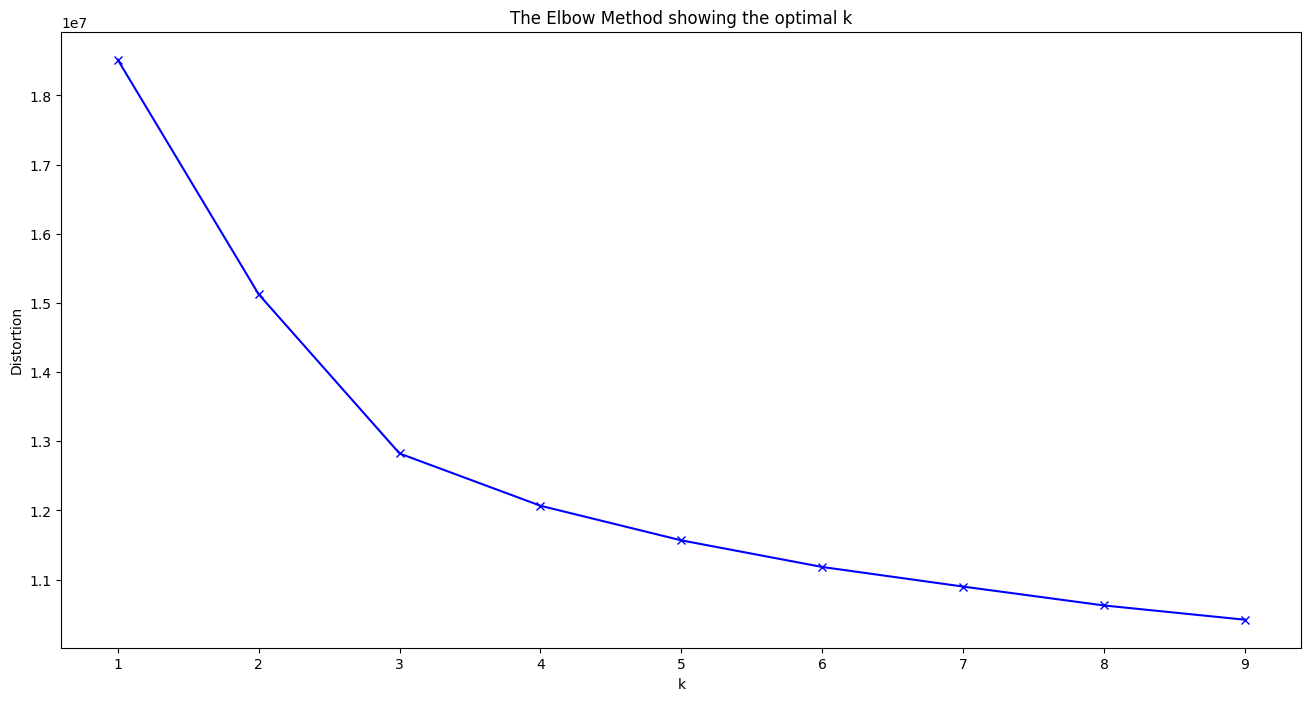

In [16]:
#Using the elbow method on Euclidean distance
elbow_method(df_euclidean, 10)

First, we have to modify our df in order to keep the first n users and assign our labels to them

Next, we'll use the PCA method in order to reduce the dimensionality of our matrix and plot our clusters

In [17]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# instantiate StandardScaler and PCA with 2 components for 2D scatter plot
scaler = StandardScaler()
pca = PCA(n_components=2)

# fit and transform the ratings matrix
ratings_pca = pca.fit_transform(ratings_matrix_df)

# print the explained variance ratio for each component
display(pca.explained_variance_ratio_)

array([0.01590064, 0.01490826])

In [18]:
# create a new dataframe with the PCA components and user index
# df_pca = pd.DataFrame(ratings_pca, index=range(0, ratings_matrix_df.shape[0]))
# df_pca['Cluster'] = labels_euclidean
# df_pca

In [19]:
#Create a function to transform the DF with PCA to 2 coordinates and create a scatter plot

def plot_pca_cluster(ratings_matrix, n_clusters):
    # instantiate StandardScaler and PCA with 2 components for 2D scatter plot
    scaler = StandardScaler()
    pca = PCA(n_components=2)

    # fit and transform the ratings matrix
    ratings_pca = pca.fit_transform(ratings_matrix)

    # apply K-means clustering
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    labels = kmeans.fit_predict(ratings_matrix)

    # create a new dataframe with the PCA components and cluster labels
    df_pca = pd.DataFrame(ratings_pca, index=range(0, ratings_matrix.shape[0]), columns=['Component 1', 'Component 2'])
    df_pca['Cluster'] = labels

    # create a scatter plot of the PCA components with color-coded clusters
    fig, ax = plt.subplots()

    for label, color in zip(df_pca['Cluster'].unique(), ['blue', 'red', 'green', 'orange', 'purple']):
        group = df_pca.groupby('Cluster').get_group(label)
        ax.scatter(group['Component 1'], group['Component 2'], c=color, label=f'Cluster {label}')

    # set the axis labels and title
    ax.set_xlabel('Component 1')
    ax.set_ylabel('Component 2')
    ax.set_title('PCA Transformed User-Movie Ratings')

    # add a legend
    ax.legend()

    # show the plot
    plt.show()

/home/thanos/.pyenv/versions/3.11.2/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


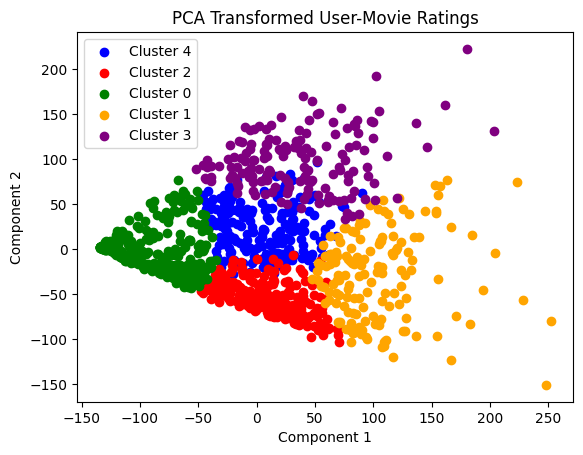

In [20]:
plot_pca_cluster(df_euclidean, L_CLUSTERS_NUM)

Να σχολιάσετε την αποτελεσματικότητα των συγκεκριμένων μετρικών στην αποτίμηση της ομοιότητας μεταξύ ενός ζεύγους διανυσμάτων προτιμήσεων χρηστών R_u και R_v.

Για την μετρική της ευκλείδιας απόστασης: 


*   Η ομοιότητα των χρηστών είναι **αντιστρόφως ανάλογη** της απόστασης μεταξύ τους.
*   Για να έχουμε αποτέλεσμα, θα πρέπει να υπάρχει **επικάλυψη μεταξύ των χρηστών.** Πρέπει δηλαδή να έχουν αξιολογήσει κοινές ταινίες.
*   Ο υπολογισμός του k-means γίνεται πολύ πιο υπολογιστικά εντατικός λόγω των εκτεταμένων πολλαπλασιασμών πινάκων που εκτελείται.


---


Για την μετρική του συνημιτόνου:


1.   Για να έχουμε αποτέλεσμα, θα πρέπει να υπάρχει **επικάλυψη μεταξύ των χρηστών.** Πρέπει δηλαδή να έχουν αξιολογήσει κοινές ταινίες.
2.   Ο υπολογισμός του k-means γίνεται πολύ πιο υπολογιστικά εντατικός λόγω των εκτεταμένων πολλαπλασιασμών πινάκων που εκτελείται.
3.   Η ομοιότητα των χρηστών μπορεί να υπολογιστεί στην περίπτωση που είναι η γωνία μεταξύ των διανυσμάτων τους από 0 - 90 ως ομοιότητα ενώ από 90 - 180 μπορούμε να εκφράσουμε την αντίθεση των χρηστών. Οπότε σε κάθε περίπτωση η μετρική μας βοηθά να ομαδοποιήσουμε τους χρήστες.





##JACCARD DISTANCE
Η απόσταση Jaccard απομετρά τη **διαφορετικότητα** μεταξύ δύο συνόλων (στην περίπτωσή μας δύο χρηστών). 



*   Στην περίπτωση που η τομή των δύο χρηστών γίνει μηδέν (δεν υπάρχουν δηλαδή κοινά αξιολογήσιμες ταινίες) η διαφορετικότητα των χρηστών παίρνει τη μέγιστη τιμή της, 1
*   Η διαφορετικότητα των χρηστών θα γίνει **ελάχιστη** όταν η *τομή* των δύο χρηστών είναι ίση με την *ένωσή* τους, όταν δηλαδή τα δύο σύνολα γίνουν *ίσα*
*   Μπορεί να χρησιμοποιηθεί για τη σύγκριση της ομοιότητας οποιουδήποτε είδους δεδομένων, συμπεριλαμβανομένων δεδομένων χρονοσειρών, φωτογραφιών, κειμένου και εικόνων.


---


Κάποια από τα μειονεκτήματα της ανωτέρω μετρικής είναι τα ακόλουθα:


---




*   **Απουσία "βαρών"**: Η απόσταση Jaccard εξετάζει μόνο την παρουσία ή την απουσία αξιολογήσεων για κάθε χρήστη και δεν λαμβάνει υπόψη τις πραγματικές τιμές αξιολόγησης. Μπορεί δηλαδή η *διαφορετικότητα*, η τιμή δηλαδή που θα προκύψει από την απόσταση Jaccard δύο χρηστών να είναι ελάχιστη, εάν έχουν αξιολογήσει τις ίδιες ταινίες ακόμα και αν ο ένας τις έχει αξιολογήσει με 5 και ο άλλος με 1.
*   **Αραιότητα αξιολογήσεων**: Για παράδειγμα, εάν δύο χρήστες έχουν αξιολογήσει μόνο έναν μικρό αριθμό ταινιών, είναι πιθανό να μην έχουν αξιολογήσει καμία από τις ίδιες ταινίες, άρα η τομή τους θα είναι μηδέν, με αποτέλεσμα η *διαφορετικότητά* τους να είναι μέγιστη, ακόμη και αν οι προτιμήσεις τους για τις ταινίες είναι στην πραγματικότητα αρκετά παρόμοιες. 




In [21]:
jaccard_dist = 1 - W
jaccard_df = pd.DataFrame(jaccard_dist)

def kmeans_clustering(jaccard_dist, L):
    # Initialize k-means object
    kmeans = KMeans(n_clusters=L)

    # Fit the k-means object to the Jaccard distance matrix
    kmeans.fit(jaccard_dist)

    return kmeans.labels_

def create_jaccard_labels_cached(jaccard_dist, L: int):
    npy_file = os.path.join(DATAFOLDER_PATH, "L_K_DEPEND_jaccard_labels.npy")
    if os.path.exists(npy_file):
        jaccard_labels: np_typing.NDArray = np.load(npy_file, allow_pickle=True)
        return jaccard_labels
    else:
        jaccard_labels = kmeans_clustering(jaccard_dist, L)
        np.save(npy_file, jaccard_labels, allow_pickle=True, fix_imports=True)
        return jaccard_labels


jaccard_labels = create_jaccard_labels_cached(jaccard_dist, L_CLUSTERS_NUM)
display('jaccard_df', jaccard_df)
display('jaccard_dist', jaccard_dist)
display('jaccard_labels', jaccard_labels)

'jaccard_df'

,0,1,2,3,4,5,6,7,8,9,...,1069,1070,1071,1072,1073,1074,1075,1076,1077,1078
0,0.000000,0.983721,0.997717,0.991031,0.990971,1.000000,0.991266,1.000000,0.997738,0.989455,...,0.977186,1.0,0.994444,0.997753,0.993421,1.000000,0.995614,0.997717,0.998267,0.990020
1,0.983721,0.000000,0.993421,0.993651,0.983819,0.990826,0.978261,0.990741,0.996764,0.995455,...,0.984962,1.0,0.995098,1.000000,0.974843,0.996815,0.984375,0.993421,1.000000,1.000000
2,0.997717,0.993421,0.000000,0.964286,0.983923,0.978462,0.993921,0.968652,0.993548,0.993197,...,0.977387,1.0,0.977667,0.990385,0.990769,0.993651,0.984472,1.000000,0.986395,1.000000
3,0.991031,0.993651,0.964286,0.000000,0.984472,0.988201,0.988166,0.985075,0.996894,0.995585,...,0.995192,1.0,0.995249,0.990712,1.000000,0.996942,0.984985,1.000000,0.997812,1.000000
4,0.990971,0.983819,0.983923,0.984472,0.000000,0.994083,0.981982,0.978788,0.980892,0.984270,...,0.967662,1.0,0.985507,0.990625,0.984894,1.000000,0.987915,1.000000,0.995585,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1074,1.000000,0.996815,0.993651,0.996942,1.000000,0.997059,0.997050,1.000000,1.000000,0.997788,...,0.995169,1.0,0.968137,0.996904,0.987988,0.000000,0.975610,0.990446,0.993377,1.000000
1075,0.995614,0.984375,0.984472,0.984985,0.987915,0.991379,0.994253,0.991304,0.996970,0.989083,...,0.975962,1.0,0.985882,0.993976,0.954819,0.975610,0.000000,0.993846,0.973568,0.994898
1076,0.997717,0.993421,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.996785,0.995475,...,0.990074,1.0,1.000000,1.000000,0.987654,0.990446,0.993846,0.000000,0.997758,0.997326
1077,0.998267,1.000000,0.986395,0.997812,0.995585,0.997872,1.000000,1.000000,1.000000,0.991349,...,0.994475,1.0,0.994526,0.997792,1.000000,0.993377,0.973568,0.997758,0.000000,1.000000


'jaccard_dist'

array([[0.        , 0.98372093, 0.99771689, ..., 0.99771689, 0.9982669 ,
        0.99001996],
       [0.98372093, 0.        , 0.99342105, ..., 0.99342105, 1.        ,
        1.        ],
       [0.99771689, 0.99342105, 0.        , ..., 1.        , 0.98639456,
        1.        ],
       ...,
       [0.99771689, 0.99342105, 1.        , ..., 0.        , 0.99775785,
        0.9973262 ],
       [0.9982669 , 1.        , 0.98639456, ..., 0.99775785, 0.        ,
        1.        ],
       [0.99001996, 1.        , 1.        , ..., 0.9973262 , 1.        ,
        0.        ]])

'jaccard_labels'

array([1, 2, 2, ..., 1, 1, 1], dtype=int32)

/home/thanos/.pyenv/versions/3.11.2/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


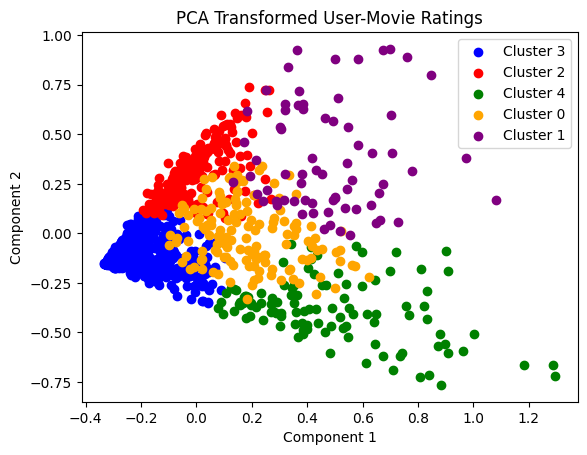

In [22]:
plot_pca_cluster(jaccard_dist, L_CLUSTERS_NUM)

# Neural Network 

### Pre - processing 

We will first start by seperating our Users according to the Cluster they've been assigned to, using the Jaccard distance on the K-Means algorithm.

We do this by creating a df containing the ratings of each user and the Cluster it belongs to.

In [23]:
ratings_matrix_clustered = ratings_matrix_df

ratings_matrix_clustered['Cluster'] = jaccard_labels

ratings_matrix_clustered

Movie,0,1,2,3,4,5,6,7,8,9,...,68075,68076,68077,68078,68079,68080,68081,68082,68083,Cluster
User,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1074,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1075,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1076,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1


In [24]:
#We sort the Labels of the Clusters from 0 to 4
# clusters = sorted(ratings_matrix_clustered.Cluster.unique())
# clusters = ratings_matrix_clustered.Cluster.unique()

# #We save each Cluster in an array where each position is for the same Cluster
# clustered_DFs: list[np_typing.NDArray] = []
# for cluster in clusters:
#     groupby_result = ratings_matrix_clustered.groupby('Cluster').get_group(cluster)
#     clustered_DFs.append(groupby_result.to_numpy())
# display('clustered_DFs', clustered_DFs)



# For each cluster find the ratings and the jaccard distances
# Each cluster_ratings array has shape (#cluster users, #total movies)
# Each cluster_jaccard_distances array has shape (#cluster users, #total users)
# Each cluster_users_indexes array has a set with len(#cluster users)

def calculate_clusters_ratings_jaccard_distances_users_indexes(L_CLUSTERS_NUM: int, jaccard_labels: np_typing.NDArray, ratings_matrix_array: np_typing.NDArray, jaccard_dist: np_typing.NDArray):
    clusters_ratings_dict = { i: [] for i in range(L_CLUSTERS_NUM)}
    clusters_jaccard_distances_dict = { i: [] for i in range(L_CLUSTERS_NUM)}
    clusters_users_indexes_dict: dict[int, set[int]] = { i: set() for i in range(L_CLUSTERS_NUM)}

    for i in range(jaccard_labels.shape[0]):
        label = jaccard_labels[i]
        cluster_ratings = clusters_ratings_dict[label]
        cluster_jaccard_distances = clusters_jaccard_distances_dict[label]
        cluster_users_indexes = clusters_users_indexes_dict[label]

        cluster_ratings.append(ratings_matrix_array[i])
        cluster_jaccard_distances.append(jaccard_dist[i])
        cluster_users_indexes.add(i)


    clusters_ratings_list: list[np_typing.NDArray] = []
    for key in clusters_ratings_dict:
        cluster_ratings = np.array(clusters_ratings_dict[key])
        clusters_ratings_list.append(cluster_ratings)


    clusters_jaccard_distances_list: list[np_typing.NDArray] = []
    for key in clusters_jaccard_distances_dict:
        cluster_jaccard_distances = np.array(clusters_jaccard_distances_dict[key])
        clusters_jaccard_distances_list.append(cluster_jaccard_distances)
    
    clusters_users_indexes_list: list[set[int]] = []
    for key in clusters_users_indexes_dict:
        clusters_users_indexes_list.append(clusters_users_indexes_dict[key])


    # clusters_ratings cotains the cluster_ratings array for each cluster
    clusters_ratings = np.array(clusters_ratings_list)
    # clusters_jaccard_distances cotains the cluster_jaccard_distances array for each cluster
    cluster_jaccard_distances = np.array(clusters_jaccard_distances_list)
    # clusters_users_indexes cotains the users indexes that belong in this cluster
    clusters_users_indexes = np.array(clusters_users_indexes_list)
    return clusters_ratings, cluster_jaccard_distances, clusters_users_indexes


clusters_ratings, clusters_jaccard_distances, clusters_users_indexes = calculate_clusters_ratings_jaccard_distances_users_indexes(L_CLUSTERS_NUM, jaccard_labels, ratings_matrix_array, jaccard_dist)
display(f'clusters_ratings[0].shape: {clusters_ratings[0].shape}')
display(f'clusters_jaccard_distances[0].shape: {clusters_jaccard_distances[0].shape}')
display(f'len(clusters_users_indexes[0]): {len(clusters_users_indexes[0])}')
display('clusters_ratings', clusters_ratings)
display('clusters_jaccard_distances', clusters_jaccard_distances)
display('clusters_users_indexes', clusters_users_indexes)

/tmp/ipykernel_16554/920973544.py:52: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  clusters_ratings = np.array(clusters_ratings_list)
/tmp/ipykernel_16554/920973544.py:54: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  cluster_jaccard_distances = np.array(clusters_jaccard_distances_list)


'clusters_ratings[0].shape: (132, 68084)'

'clusters_jaccard_distances[0].shape: (132, 1079)'

'len(clusters_users_indexes[0]): 132'

'clusters_ratings'

array([array([[0., 0., 0., ..., 0., 0., 0.],
              [0., 0., 0., ..., 0., 0., 0.],
              [0., 0., 0., ..., 0., 0., 0.],
              ...,
              [0., 0., 0., ..., 0., 0., 0.],
              [0., 0., 0., ..., 0., 0., 0.],
              [0., 0., 0., ..., 0., 0., 0.]]),
       array([[0., 0., 0., ..., 0., 0., 0.],
              [0., 0., 0., ..., 0., 0., 0.],
              [0., 0., 0., ..., 0., 0., 0.],
              ...,
              [0., 0., 0., ..., 0., 0., 0.],
              [0., 0., 0., ..., 0., 0., 0.],
              [0., 0., 0., ..., 0., 0., 0.]]),
       array([[0., 0., 0., ..., 0., 0., 0.],
              [0., 0., 0., ..., 0., 0., 0.],
              [0., 0., 0., ..., 0., 0., 0.],
              ...,
              [0., 0., 0., ..., 0., 0., 0.],
              [0., 0., 0., ..., 0., 0., 0.],
              [0., 0., 0., ..., 0., 0., 0.]]),
       array([[0., 0., 0., ..., 0., 0., 0.],
              [0., 0., 0., ..., 0., 0., 0.],
              [0., 0., 0., ..., 0., 0

'clusters_jaccard_distances'

array([array([[0.9869403 , 0.98263027, 0.99512195, ..., 0.99512195, 0.99635701,
               0.99580713],
              [0.99125874, 0.97695853, 1.        , ..., 0.99095023, 0.99311532,
               0.99608611],
              [0.96806387, 0.976     , 0.9921671 , ..., 0.9895288 , 0.99232246,
               0.99778761],
              ...,
              [0.99558499, 0.97452229, 0.9875    , ..., 0.99378882, 0.99347826,
               0.99226804],
              [1.        , 0.99681529, 0.99365079, ..., 0.99044586, 0.99337748,
               1.        ],
              [0.99561404, 0.984375  , 0.98447205, ..., 0.99384615, 0.97356828,
               0.99489796]])                                                   ,
       array([[0.        , 0.98372093, 0.99771689, ..., 0.99771689, 0.9982669 ,
               0.99001996],
              [0.99103139, 0.99365079, 0.96428571, ..., 1.        , 0.99781182,
               1.        ],
              [1.        , 0.99082569, 0.97846154, ..., 1.      

'clusters_users_indexes'

array([{516, 517, 1033, 522, 1034, 524, 528, 532, 1046, 1050, 540, 541, 1055, 1056, 547, 1061, 553, 1066, 557, 559, 1074, 1075, 565, 566, 571, 577, 583, 587, 595, 602, 94, 611, 615, 619, 631, 637, 645, 648, 649, 651, 142, 656, 658, 659, 661, 150, 665, 666, 667, 680, 171, 172, 685, 686, 694, 183, 695, 702, 705, 706, 708, 198, 710, 712, 726, 731, 220, 734, 224, 741, 742, 743, 745, 251, 763, 766, 258, 261, 782, 787, 789, 285, 802, 294, 295, 810, 301, 815, 304, 305, 818, 310, 822, 823, 318, 831, 837, 838, 853, 856, 857, 862, 351, 868, 359, 361, 364, 884, 890, 894, 897, 898, 902, 907, 913, 404, 917, 415, 416, 930, 422, 951, 961, 974, 983, 472, 990, 991, 481, 994, 996, 1009},
       {0, 3, 5, 7, 8, 9, 10, 11, 12, 13, 14, 15, 17, 18, 19, 21, 24, 25, 26, 27, 28, 31, 34, 35, 36, 39, 41, 43, 44, 45, 47, 51, 54, 55, 56, 58, 60, 61, 62, 63, 65, 66, 68, 72, 75, 78, 79, 81, 83, 84, 87, 90, 95, 97, 98, 102, 106, 107, 108, 110, 112, 118, 120, 123, 124, 125, 126, 127, 128, 129, 130, 132, 134, 137, 138,

In [25]:
from sklearn.neighbors import NearestNeighbors

# define the custom distance metric based on Jaccard similarity score
# def custom_distance(u, v):
#     intersection = len(set(u).intersection(set(v)))
#     union = len(set(u).union(set(v)))
#     similarity = intersection / union
#     return 1 - similarity


# def find_nearest_neighbors(cluster_ratings_binary: np_typing.NDArray, k: int):
#     # instantiate the NearestNeighbors model with the custom distance metric
#     model = NearestNeighbors(n_neighbors=k, algorithm='auto', metric=custom_distance)

#     # fit the model on the ratings matrix
#     model.fit(cluster_ratings_binary)

#     # find the k-nearest neighbors for each user
#     k_nearest_neighbors: list[list[int]] = []
    
#     distances, indices = model.kneighbors(cluster_ratings_binary, n_neighbors=k+1) # get indices of k+1 most similar users (including the user itself)
#     for i in range(indices.shape[0]):
#         # exclude the user itself
#         neighbors = [index for index in indices[i] if index != i]
#         k_nearest_neighbors.append(neighbors[:k])


#     display('cluster_ratings_binary.shape', cluster_ratings_binary.shape)
#     display('indices.shape', indices.shape)
#     display('indices', indices)

    # for i in range(cluster_ratings.shape[0]):
    #     # _, indices = model.kneighbors([cluster_ratings[i]], n_neighbors=k+1) # get indices of k+1 most similar users (including the user itself)

    #     # if we want to get the distance for each pair of users
    #     # neighbors = [(index, custom_distance(ratings[i], ratings[index])) for index in indices[0] if index != i] 
    #     neighbors = [index for index in indices[0] if index != i]
    #     # exclude the user itself
    #     k_nearest_neighbors.append(neighbors[:k])

    # We save our k_nearest_neighbors as a dict where for each user, we get the 
    # most similar of their users. This will allow us to 
    # Create a NN where the INPUT: will be the ratings of similar users
    # and OUTPUT: the rating of the user we currently have.
    # return np.array(k_nearest_neighbors)


# def calculate_jaccard_value(source_ratings: np_typing.NDArray, target_ratings: np_typing.NDArray):
#     n = source_ratings.shape[0]
#     intersection_len = 0
#     union_len = 0
#     for i in range(n):
#         if source_ratings[i] != 0.0 and target_ratings[i] != 0.0:
#             intersection_len += 1
        

#         if source_ratings[i] != 0.0 or target_ratings[i] != 0.0:
#             union_len += 1


#     return 1 - intersection_len / union_len


# def create_cluster_jaccard(cluster_ratings: np_typing.NDArray):
#     cluster_users_num = cluster_ratings.shape[0]
#     jaccard_lists: list[list[float]] = []
#     for source_user in range(cluster_users_num):
#         jaccard_list: list[float] = []
#         for target_user in range(cluster_users_num):
#             jaccard_value = calculate_jaccard_value(cluster_ratings[source_user], cluster_ratings[target_user])
#             jaccard_list.append(jaccard_value)
        

#         jaccard_lists.append(jaccard_list)


#     return np.array(jaccard_lists)


# def find_nearest_neighbors_using_jaccard(cluster_ratings: np_typing.NDArray, k: int):
#     cluster_jaccard = create_cluster_jaccard(cluster_ratings)
#     display('cluster_jaccard', cluster_jaccard)

#     nearest_neighbors_list: list[np_typing.NDArray] = []
#     for row_index in range(cluster_jaccard.shape[0]):
#         cluster_jaccard_row = cluster_jaccard[row_index]
#         k_nearest_indexes = np.argpartition(cluster_jaccard_row, k)
#         k_nearest_indexes = k_nearest_indexes[k_nearest_indexes != row_index]
#         nearest_neighbors_list.append(k_nearest_indexes[:k])
        
    
#     return np.array(nearest_neighbors_list)

def find_nearest_neighbors_using_jaccard(K_NEIGHBORS_NUM: int, cluster_jaccard_distances: np_typing.NDArray, cluster_users_indexes: set[int]):
    nearest_neighbors_list: list[np_typing.NDArray] = []
    for row_index in range(cluster_jaccard_distances.shape[0]):
        cluster_jaccard_row = cluster_jaccard_distances[row_index]
        
        ## set the distance of the users that are the same a index to a value higher thatn 1
        for j in range(cluster_jaccard_row.shape[0]):
            if j == row_index or not(j in cluster_users_indexes):
                cluster_jaccard_row[j] = 2

        ## find the k smallest indexes
        k_nearest_indexes = np.argpartition(cluster_jaccard_row, K_NEIGHBORS_NUM)
        # k_nearest_indexes = k_nearest_indexes[k_nearest_indexes != row_index]
        nearest_neighbors_list.append(k_nearest_indexes[:K_NEIGHBORS_NUM])        
    
    return np.array(nearest_neighbors_list)


def create_clusters_nearest_neighbors_cached(K_NEIGHBORS_NUM: int, clusters_jaccard_distances: np_typing.NDArray, clusters_users_indexes: np_typing.NDArray):
    #Set the npy file that will store the clusters_nearest_neighbors
    npy_file = os.path.join(DATAFOLDER_PATH, "L_K_DEPEND_clusters_nearest_neighbors.npy")
    if os.path.exists(npy_file):
        clusters_nearest_neighbors: np_typing.NDArray[np.float64] = np.load(npy_file, allow_pickle=True)
        return clusters_nearest_neighbors
    else:
        clusters_nearest_neighbors_list: list[np_typing.NDArray] = []        
        for index in range(clusters_jaccard_distances.shape[0]):
            cluster_jaccard_distances = clusters_jaccard_distances[index]
            # cluster_ratings_binary = np.where(cluster_ratings > 0, 1, 0)
            # nearest_neihbors = find_nearest_neighbors(cluster_ratings_binary, k)
            nearest_neihbors = find_nearest_neighbors_using_jaccard(K_NEIGHBORS_NUM, clusters_jaccard_distances[index].copy(), clusters_users_indexes[index])
            display('nearest_neihbors', nearest_neihbors)
            clusters_nearest_neighbors_list.append(nearest_neihbors)            
        
        
        clusters_nearest_neighbors = np.array(clusters_nearest_neighbors_list)
        np.save(npy_file, clusters_nearest_neighbors, allow_pickle=True, fix_imports=True)
        return clusters_nearest_neighbors
    

clusters_nearest_neighbors = create_clusters_nearest_neighbors_cached(K_NEIGHBORS_NUM, clusters_jaccard_distances, clusters_users_indexes)
display('clusters_nearest_neighbors', clusters_nearest_neighbors)

# # instantiate the NearestNeighbors model with the custom distance metric
# model = NearestNeighbors(n_neighbors=k, algorithm='brute', metric=custom_distance)

# cluster_ratings = clustered_DFs[1]
# # fit the model on the ratings matrix
# model.fit(cluster_ratings)

# # find the k-nearest neighbors for each user
# k_nearest_neighbors = {}
# for i in range(cluster_ratings.shape[0]):
#     _, indices = model.kneighbors([cluster_ratings[i]], n_neighbors=k+1) # get indices of k+1 most similar users (including the user itself)
#     # if we want to get the distance for each pair of users
#     # neighbors = [(index, custom_distance(ratings[i], ratings[index])) for index in indices[0] if index != i] 
#     neighbors = [index for index in indices[0] if index != i]
#  # exclude the user itself
#     k_nearest_neighbors[i] = neighbors

# # We save our k_nearest_neighbors as a dict where for each user, we get the 
# # most similar of their users. This will allow us to 
# # Create a NN where the INPUT: will be the ratings of similar users
# # and OUTPUT: the rating of the user we currently have.


'clusters_nearest_neighbors'

array([array([[ 667,  637,   94,  743,  710,  831],
              [1056,  656,  142,  150,  726,  602],
              [ 649,  656,  150,  726,  142, 1056],
              [ 656,  917,  890,  171,  726,  658],
              [ 142,  172,  261,  285,  517,  304],
              [ 815,  183,  726, 1050, 1056,  351],
              [ 667,  198,  710,  743,  838,  637],
              [1056,  220,  142,  708,  726,  285],
              [ 810,  224,  659,  667,  318,  838],
              [ 667,  472,  731,  645,  251,  649],
              [ 258, 1056,  285,  726,  304,  602],
              [ 831,  285,  261,  172,  310,  838],
              [ 285,  917,  990, 1056,  142,  304],
              [ 142,  565,  472,  726,  602,  294],
              [ 295,  472,  142,  557,  615,  150],
              [ 301,  659,  310,  763,  631,  602],
              [ 304,  285,  656,  142, 1056,  602],
              [ 708,  743,  305,  710,  637,  818],
              [ 261,  310,  631,  862,  743,  831],
            

#Creating the NN

In [26]:
import tensorflow as tf
import numpy as np



# collect the ratings of the similar users and the target user
# similar_user_ratings = []
# target_user_ratings = []
# cluster_ratings = cluster_ratings / 5
# for i, neighbors in k_nearest_neighbors.items():
#     similar_ratings = cluster_ratings[neighbors]
#     target_ratings = cluster_ratings[i]
#     similar_user_ratings.append(similar_ratings)
#     target_user_ratings.append(target_ratings)

# # convert the lists of ratings to numpy arrays
# similar_user_ratings = np.array(similar_user_ratings)
# target_user_ratings = np.array(target_user_ratings)

# create a neural network model
# model = tf.keras.Sequential([
#     tf.keras.layers.Dense(256, activation='relu', input_shape=(k, 5043)),
#     tf.keras.layers.Dense(128, activation='relu'),
#     tf.keras.layers.Dense(5043)
# ])

# # compile the model with an appropriate optimizer and loss function
# model.compile(optimizer='adam', loss='mse')
# # train the model using the nearest neighbors' ratings as input and the user's rating as output
# for user_id in range(ratings.shape[0]):
#     neighbors_ratings = [ratings[neighbor] for neighbor in k_nearest_neighbors[user_id] if neighbor != user_id]
#     user_rating = ratings[user_id]
#     X = np.array([neighbors_ratings])
#     print(X.shape)
#     y = np.array([user_rating])
#     model.fit(X, y, epochs=10, batch_size=32)

# THANOS NEURAL NETWORK

In [30]:
def create_nn_original_df(ratings_matrix_array: np_typing.NDArray, cluster_ratings: np_typing.NDArray, nearest_neighbors: np_typing.NDArray, NEIGHBOURS_COLUMNS: list[str]):
    # create user_ratings_list
    user_index_list: list[int] = []
    movie_index_list: list[int] = []
    user_ratings_list: list[int] = []
    for i in range(nearest_neighbors.shape[0]):
        user_index_list.extend([i for ratings in cluster_ratings[i]])
        movie_index_list.extend([j for j in range(cluster_ratings[i].shape[0])])
        user_ratings_list.extend(cluster_ratings[i])
        
    # create neighbors list
    neighbors_list: list[list[int]] = []
    for i in range(nearest_neighbors.shape[1]):
        neighbor_ratings_list: list[int] = []

        for j in range(nearest_neighbors.shape[0]):
            neighbor = nearest_neighbors[j][i]
            # nearest neighbors have indexs for the ratings_matrix_array up to total users
            # so use ratings_matrix_array instead of cluster_ratings.
            # We have previously ensured that all neighbors belong to this clusters
            neighbor_ratings_list.extend(ratings_matrix_array[neighbor])

        neighbors_list.append(neighbor_ratings_list)


    nn_origin_df = pd.DataFrame()
    nn_origin_df['USER_INDEX'] = user_index_list
    nn_origin_df['MOVIE_INDEX'] = movie_index_list
    nn_origin_df['USER_RATINGS'] = user_ratings_list

    for i in range(len(neighbors_list)):
        neighbor_ratings_list: list[int] = neighbors_list[i]
        nn_origin_df[NEIGHBOURS_COLUMNS[i]] = neighbor_ratings_list


    return nn_origin_df


def create_clusters_nn_original_dfs_cached(ratings_matrix_array: np_typing.NDArray, clusters_ratings: np_typing.NDArray, clusters_nearest_neighbors: np_typing.NDArray, NEIGHBOURS_COLUMNS: list[str]):
    for cluster_index in range(len(clusters_ratings)):
        pickle_file = os.path.join(DATAFOLDER_PATH, f"L_K_DEPEND_clusters_nn_original_dfs_{cluster_index}.pkl")
        if os.path.exists(pickle_file):
            print('exists')
        else:
            cluster_ratings = clusters_ratings[cluster_index]
            nearest_neighbors = clusters_nearest_neighbors[cluster_index]    

            nn_origin_df = create_nn_original_df(ratings_matrix_array, cluster_ratings, nearest_neighbors, NEIGHBOURS_COLUMNS)
            nn_origin_df.to_pickle(pickle_file)
            nn_origin_df = None


ratings_normalize_factor: float = ratings_matrix_df.max().max()
# NOTE: ratings_normalize_factor == 1 (not normalizing data) produces better results from normalizing data
ratings_normalize_factor = 1

NEIGHBOURS_COLUMNS = [f'NEIGHBOR_RATINGS_{i}' for i in range(K_NEIGHBORS_NUM)]

create_clusters_nn_original_dfs_cached(ratings_matrix_array, clusters_ratings, clusters_nearest_neighbors, NEIGHBOURS_COLUMNS)

'ratings_normalize_factor'

1

'Dataframe with filter user ratings (non zero) and neighbors ratings scaled by maximum rating'

,USER_INDEX,MOVIE_INDEX,USER_RATINGS,NEIGHBOR_RATINGS_0,NEIGHBOR_RATINGS_1,NEIGHBOR_RATINGS_2,NEIGHBOR_RATINGS_3,NEIGHBOR_RATINGS_4,NEIGHBOR_RATINGS_5
428,0,428,7.0,0.0,0.0,7.0,0.0,0.0,0.0
7518,0,7518,4.0,0.0,0.0,4.0,0.0,0.0,0.0
8140,0,8140,7.0,0.0,0.0,7.0,0.0,0.0,0.0
8872,0,8872,7.0,0.0,0.0,7.0,10.0,0.0,0.0
9612,0,9612,4.0,0.0,0.0,4.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...
8983410,131,64406,7.0,7.0,0.0,0.0,0.0,0.0,0.0
8983546,131,64542,7.0,7.0,0.0,0.0,0.0,7.0,9.0
8984148,131,65144,4.0,4.0,0.0,0.0,0.0,0.0,0.0
8985977,131,66973,1.0,1.0,0.0,0.0,0.0,0.0,0.0


,USER_INDEX,MOVIE_INDEX,USER_RATINGS,NEIGHBOR_RATINGS_0,NEIGHBOR_RATINGS_1,NEIGHBOR_RATINGS_2,NEIGHBOR_RATINGS_3,NEIGHBOR_RATINGS_4,NEIGHBOR_RATINGS_5
count,28189.000000,28189.000000,28189.000000,28189.000000,28189.000000,28189.000000,28189.000000,28189.000000,28189.000000
mean,64.485792,40406.828231,6.790450,3.273724,3.068963,2.679308,2.045727,1.754088,1.430310
std,38.348351,14515.308105,2.314765,3.786632,3.806246,3.685644,3.383530,3.243748,3.040596
min,0.000000,7.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,31.000000,30059.000000,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,64.000000,44160.000000,7.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,97.000000,50755.000000,8.000000,7.000000,7.000000,6.000000,5.000000,0.000000,0.000000
max,131.000000,68073.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000


'train_df'

,USER_INDEX,MOVIE_INDEX,USER_RATINGS,NEIGHBOR_RATINGS_0,NEIGHBOR_RATINGS_1,NEIGHBOR_RATINGS_2,NEIGHBOR_RATINGS_3,NEIGHBOR_RATINGS_4,NEIGHBOR_RATINGS_5
8284068,121,45904,10.0,0.0,10.0,0.0,0.0,0.0,0.0
6771291,99,30975,6.0,6.0,0.0,0.0,0.0,0.0,0.0
1545692,22,47844,6.0,6.0,0.0,4.0,0.0,0.0,0.0
6456126,94,56230,6.0,0.0,0.0,6.0,0.0,0.0,0.0
6319535,92,55807,10.0,0.0,10.0,0.0,8.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...
6790046,99,49730,2.0,2.0,4.0,3.0,0.0,0.0,0.0
1611827,23,45895,6.0,0.0,6.0,0.0,0.0,0.0,0.0
222212,3,17960,9.0,9.0,10.0,10.0,9.0,0.0,0.0
4943526,72,41478,10.0,10.0,0.0,0.0,0.0,0.0,0.0


'test_df'

,USER_INDEX,MOVIE_INDEX,USER_RATINGS,NEIGHBOR_RATINGS_0,NEIGHBOR_RATINGS_1,NEIGHBOR_RATINGS_2,NEIGHBOR_RATINGS_3,NEIGHBOR_RATINGS_4,NEIGHBOR_RATINGS_5
234294,3,30042,1.0,0.0,0.0,0.0,1.0,0.0,0.0
6988854,102,44286,10.0,10.0,0.0,7.0,0.0,0.0,0.0
2148922,31,38318,4.0,7.0,7.0,4.0,0.0,0.0,0.0
8563736,125,53236,8.0,9.0,8.0,9.0,8.0,8.0,9.0
3725272,54,48736,5.0,6.0,6.0,6.0,5.0,9.0,0.0
...,...,...,...,...,...,...,...,...,...
4858106,71,24142,8.0,8.0,0.0,0.0,8.0,0.0,0.0
6499125,95,31145,6.0,0.0,6.0,0.0,0.0,7.0,0.0
7577077,111,19753,10.0,0.0,10.0,0.0,10.0,0.0,0.0
325354,4,53018,9.0,0.0,9.0,0.0,0.0,0.0,0.0


'Training the model with the train_df'

Epoch 1/64
177/177 [==============================] - 1s 605us/step - loss: 15.6255 - mean_squared_error: 15.0851 - mean_absolute_error: 2.8019
Epoch 2/64
177/177 [==============================] - 0s 586us/step - loss: 2.1718 - mean_squared_error: 1.6585 - mean_absolute_error: 0.8437
Epoch 3/64
177/177 [==============================] - 0s 590us/step - loss: 1.8732 - mean_squared_error: 1.3824 - mean_absolute_error: 0.7304
Epoch 4/64
177/177 [==============================] - 0s 603us/step - loss: 1.7569 - mean_squared_error: 1.2867 - mean_absolute_error: 0.6702
Epoch 5/64
177/177 [==============================] - 0s 594us/step - loss: 1.6747 - mean_squared_error: 1.2241 - mean_absolute_error: 0.6230
Epoch 6/64
177/177 [==============================] - 0s 602us/step - loss: 1.6119 - mean_squared_error: 1.1798 - mean_absolute_error: 0.5890
Epoch 7/64
177/177 [==============================] - 0s 592us/step - loss: 1.5608 - mean_squared_error: 1.1461 - mean_absolute_error: 0.5704
Epoc

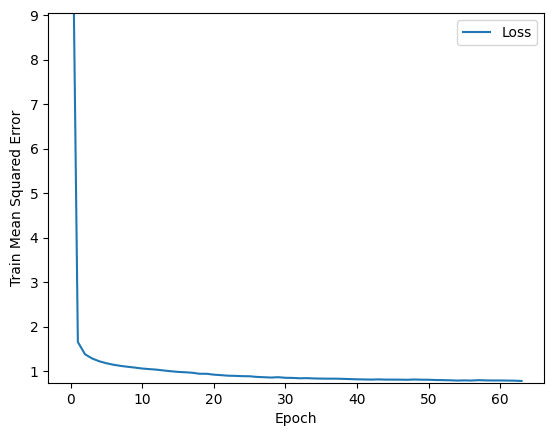

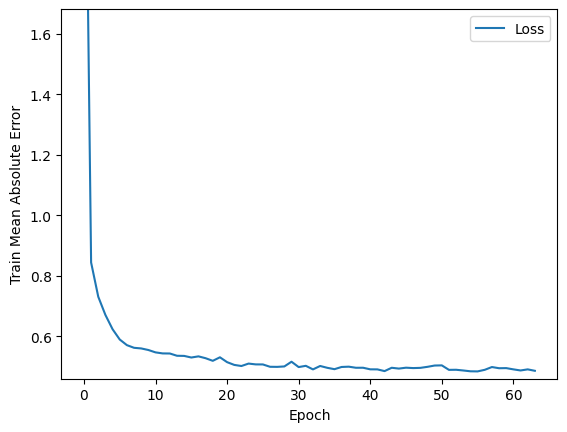

'Evaluating the model against the test_df'

45/45 [==============================] - 0s 530us/step - loss: 0.9797 - mean_squared_error: 0.8249 - mean_absolute_error: 0.4788


'Predicting the nn_origin_df and comparing with the initial data'

70212/70212 [==============================] - 26s 371us/step


'predictions'

array([0.9154237, 0.9154237, 0.9154237, ..., 0.9154237, 0.9154237,
       0.9154237], dtype=float32)

'predictions.shape'

(8987088,)

'real_ratings'

array([0., 0., 0., ..., 0., 0., 0.])

'real_mean_squared_error=0.47310784578687054, real_mean_absolute_error=0.5254776077988053'

'Dataframe with filter user ratings (non zero) and neighbors ratings scaled by maximum rating'

,USER_INDEX,MOVIE_INDEX,USER_RATINGS,NEIGHBOR_RATINGS_0,NEIGHBOR_RATINGS_1,NEIGHBOR_RATINGS_2,NEIGHBOR_RATINGS_3,NEIGHBOR_RATINGS_4,NEIGHBOR_RATINGS_5
279,0,279,9.0,0.0,0.0,8.0,0.0,0.0,0.0
312,0,312,10.0,0.0,0.0,9.0,0.0,0.0,0.0
4300,0,4300,9.0,0.0,0.0,0.0,9.0,0.0,0.0
4344,0,4344,10.0,8.0,0.0,0.0,0.0,0.0,0.0
5644,0,5644,10.0,0.0,0.0,0.0,10.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...
34654586,508,67914,7.0,7.0,0.0,0.0,0.0,0.0,0.0
34654594,508,67922,9.0,9.0,0.0,0.0,0.0,0.0,0.0
34654595,508,67923,8.0,8.0,0.0,0.0,0.0,0.0,0.0
34654601,508,67929,7.0,7.0,0.0,0.0,0.0,0.0,0.0


,USER_INDEX,MOVIE_INDEX,USER_RATINGS,NEIGHBOR_RATINGS_0,NEIGHBOR_RATINGS_1,NEIGHBOR_RATINGS_2,NEIGHBOR_RATINGS_3,NEIGHBOR_RATINGS_4,NEIGHBOR_RATINGS_5
count,103067.000000,103067.000000,103067.000000,103067.000000,103067.000000,103067.000000,103067.000000,103067.00000,103067.000000
mean,254.438016,32878.664083,6.469200,2.378307,2.121106,1.728031,1.114168,0.72808,0.413585
std,147.288241,20072.509949,2.569245,3.501402,3.376742,3.194245,2.677186,2.22500,1.717450
min,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
25%,126.000000,14321.500000,5.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
50%,254.000000,32278.000000,7.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
75%,382.000000,50649.000000,8.000000,6.000000,5.000000,1.000000,0.000000,0.00000,0.000000
max,508.000000,68083.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.00000,10.000000


'train_df'

,USER_INDEX,MOVIE_INDEX,USER_RATINGS,NEIGHBOR_RATINGS_0,NEIGHBOR_RATINGS_1,NEIGHBOR_RATINGS_2,NEIGHBOR_RATINGS_3,NEIGHBOR_RATINGS_4,NEIGHBOR_RATINGS_5
6012854,88,21462,10.0,10.0,0.0,0.0,0.0,0.0,0.0
25260847,371,1683,9.0,0.0,9.0,5.0,0.0,0.0,8.0
17665191,259,31435,10.0,0.0,3.0,10.0,0.0,0.0,0.0
17369749,255,8329,7.0,7.0,0.0,0.0,0.0,0.0,0.0
31850878,467,55650,4.0,0.0,0.0,4.0,6.0,8.0,0.0
...,...,...,...,...,...,...,...,...,...
2123538,31,12934,5.0,0.0,0.0,5.0,0.0,0.0,0.0
18451804,271,1040,8.0,0.0,8.0,0.0,0.0,0.0,0.0
25860711,379,56875,8.0,0.0,0.0,8.0,0.0,0.0,0.0
353889,5,13469,4.0,4.0,0.0,0.0,0.0,0.0,0.0


'test_df'

,USER_INDEX,MOVIE_INDEX,USER_RATINGS,NEIGHBOR_RATINGS_0,NEIGHBOR_RATINGS_1,NEIGHBOR_RATINGS_2,NEIGHBOR_RATINGS_3,NEIGHBOR_RATINGS_4,NEIGHBOR_RATINGS_5
27296035,400,62435,5.0,0.0,0.0,5.0,0.0,0.0,0.0
15067071,221,20507,9.0,9.0,0.0,0.0,0.0,0.0,0.0
6232629,91,36985,7.0,0.0,7.0,7.0,0.0,0.0,0.0
8194834,120,24754,6.0,6.0,0.0,0.0,0.0,0.0,0.0
25947033,381,7029,9.0,0.0,9.0,9.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...
1099172,16,9828,4.0,0.0,4.0,0.0,0.0,0.0,0.0
19101297,280,37777,5.0,5.0,7.0,0.0,0.0,0.0,0.0
23400369,343,47557,7.0,0.0,0.0,7.0,0.0,0.0,0.0
23400806,343,47994,8.0,0.0,0.0,8.0,0.0,0.0,0.0


'Training the model with the train_df'

Epoch 1/64
645/645 [==============================] - 1s 617us/step - loss: 3.7311 - mean_squared_error: 3.2991 - mean_absolute_error: 0.9463
Epoch 2/64
645/645 [==============================] - 0s 589us/step - loss: 1.0729 - mean_squared_error: 0.7157 - mean_absolute_error: 0.3363
Epoch 3/64
645/645 [==============================] - 0s 593us/step - loss: 0.9684 - mean_squared_error: 0.6587 - mean_absolute_error: 0.3229
Epoch 4/64
645/645 [==============================] - 0s 587us/step - loss: 0.8919 - mean_squared_error: 0.6177 - mean_absolute_error: 0.3065
Epoch 5/64
645/645 [==============================] - 0s 586us/step - loss: 0.8384 - mean_squared_error: 0.5897 - mean_absolute_error: 0.2984
Epoch 6/64
645/645 [==============================] - 0s 585us/step - loss: 0.7983 - mean_squared_error: 0.5703 - mean_absolute_error: 0.2964
Epoch 7/64
645/645 [==============================] - 0s 593us/step - loss: 0.7679 - mean_squared_error: 0.5577 - mean_absolute_error: 0.2970
Epoch 

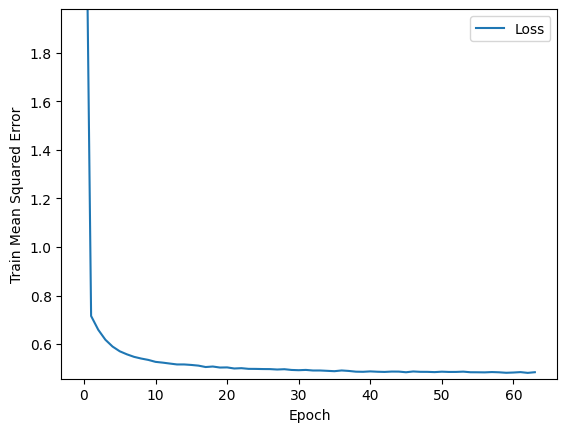

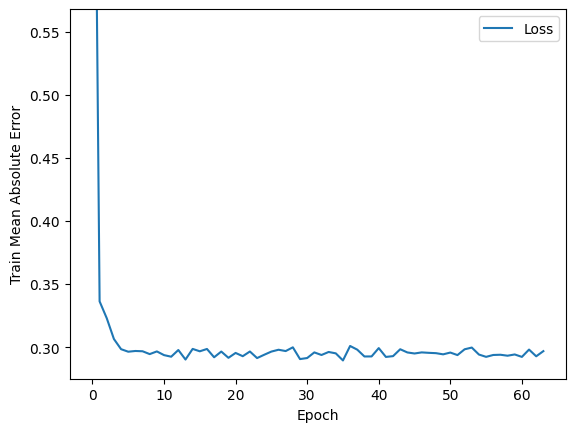

'Evaluating the model against the test_df'

162/162 [==============================] - 0s 510us/step - loss: 0.5920 - mean_squared_error: 0.5133 - mean_absolute_error: 0.3122


'Predicting the nn_origin_df and comparing with the initial data'

270741/270741 [==============================] - 104s 384us/step


'predictions'

array([1.1631923, 1.1631923, 7.103224 , ..., 1.1631923, 1.1631923,
       1.1631923], dtype=float32)

'predictions.shape'

(34654756,)

'real_ratings'

array([0., 0., 0., ..., 0., 0., 0.])

'real_mean_squared_error=0.32191863187910563, real_mean_absolute_error=0.4406567686668506'

'Dataframe with filter user ratings (non zero) and neighbors ratings scaled by maximum rating'

,USER_INDEX,MOVIE_INDEX,USER_RATINGS,NEIGHBOR_RATINGS_0,NEIGHBOR_RATINGS_1,NEIGHBOR_RATINGS_2,NEIGHBOR_RATINGS_3,NEIGHBOR_RATINGS_4,NEIGHBOR_RATINGS_5
10977,0,10977,10.0,0.0,10.0,0.0,0.0,0.0,0.0
13843,0,13843,10.0,0.0,10.0,0.0,0.0,0.0,0.0
15013,0,15013,10.0,0.0,10.0,0.0,0.0,0.0,0.0
15699,0,15699,10.0,0.0,10.0,0.0,0.0,0.0,0.0
16995,0,16995,6.0,0.0,6.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...
15794269,231,66865,6.0,0.0,6.0,0.0,0.0,0.0,0.0
15794272,231,66868,2.0,0.0,2.0,0.0,0.0,0.0,0.0
15794414,231,67010,8.0,0.0,8.0,0.0,0.0,0.0,0.0
15794454,231,67050,6.0,0.0,6.0,0.0,0.0,0.0,0.0


,USER_INDEX,MOVIE_INDEX,USER_RATINGS,NEIGHBOR_RATINGS_0,NEIGHBOR_RATINGS_1,NEIGHBOR_RATINGS_2,NEIGHBOR_RATINGS_3,NEIGHBOR_RATINGS_4,NEIGHBOR_RATINGS_5
count,47725.000000,47725.000000,47725.000000,47725.000000,47725.000000,47725.000000,47725.000000,47725.000000,47725.000000
mean,115.907365,27817.192352,6.831577,2.930141,2.673148,1.971063,1.408759,1.356983,0.978502
std,66.809760,13448.745119,2.502502,3.800095,3.694482,3.364768,3.012268,2.968922,2.606912
min,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,59.000000,17881.000000,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,115.000000,27848.000000,7.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,174.000000,38182.000000,9.000000,7.000000,6.000000,4.000000,0.000000,0.000000,0.000000
max,231.000000,68079.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000


'train_df'

,USER_INDEX,MOVIE_INDEX,USER_RATINGS,NEIGHBOR_RATINGS_0,NEIGHBOR_RATINGS_1,NEIGHBOR_RATINGS_2,NEIGHBOR_RATINGS_3,NEIGHBOR_RATINGS_4,NEIGHBOR_RATINGS_5
14267373,209,37817,6.0,4.0,0.0,6.0,1.0,4.0,2.0
5079676,74,41460,8.0,0.0,0.0,8.0,0.0,0.0,0.0
3975817,58,26945,5.0,0.0,0.0,0.0,5.0,0.0,0.0
14814956,217,40728,6.0,0.0,6.0,0.0,0.0,0.0,0.0
13390299,196,45835,1.0,1.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...
3824039,56,11335,9.0,9.0,0.0,0.0,0.0,0.0,0.0
14849659,218,7347,4.0,0.0,4.0,0.0,0.0,0.0,0.0
12641224,185,45684,8.0,8.0,0.0,0.0,0.0,0.0,0.0
353658,5,13238,8.0,0.0,8.0,0.0,0.0,0.0,0.0


'test_df'

,USER_INDEX,MOVIE_INDEX,USER_RATINGS,NEIGHBOR_RATINGS_0,NEIGHBOR_RATINGS_1,NEIGHBOR_RATINGS_2,NEIGHBOR_RATINGS_3,NEIGHBOR_RATINGS_4,NEIGHBOR_RATINGS_5
6076135,89,16659,7.0,0.0,0.0,7.0,0.0,10.0,0.0
567371,8,22699,3.0,0.0,0.0,3.0,0.0,0.0,0.0
5267295,77,24827,7.0,0.0,7.0,5.0,0.0,0.0,6.0
2556323,37,37215,7.0,7.0,7.0,5.0,0.0,0.0,0.0
11986479,176,3695,9.0,0.0,9.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...
2832041,41,40597,7.0,10.0,0.0,0.0,7.0,0.0,0.0
12507661,183,48289,6.0,0.0,0.0,6.0,0.0,0.0,0.0
14069089,206,43785,6.0,0.0,6.0,0.0,0.0,0.0,0.0
11055299,162,25691,8.0,8.0,0.0,0.0,0.0,8.0,0.0


'Training the model with the train_df'

Epoch 1/64
299/299 [==============================] - 1s 595us/step - loss: 5.8934 - mean_squared_error: 5.3842 - mean_absolute_error: 1.4669
Epoch 2/64
299/299 [==============================] - 0s 572us/step - loss: 1.8911 - mean_squared_error: 1.4052 - mean_absolute_error: 0.6537
Epoch 3/64
299/299 [==============================] - 0s 577us/step - loss: 1.7147 - mean_squared_error: 1.2509 - mean_absolute_error: 0.5715
Epoch 4/64
299/299 [==============================] - 0s 606us/step - loss: 1.6228 - mean_squared_error: 1.1799 - mean_absolute_error: 0.5314
Epoch 5/64
299/299 [==============================] - 0s 614us/step - loss: 1.5571 - mean_squared_error: 1.1349 - mean_absolute_error: 0.5136
Epoch 6/64
299/299 [==============================] - 0s 590us/step - loss: 1.4983 - mean_squared_error: 1.0951 - mean_absolute_error: 0.4997
Epoch 7/64
299/299 [==============================] - 0s 604us/step - loss: 1.4524 - mean_squared_error: 1.0669 - mean_absolute_error: 0.4937
Epoch 

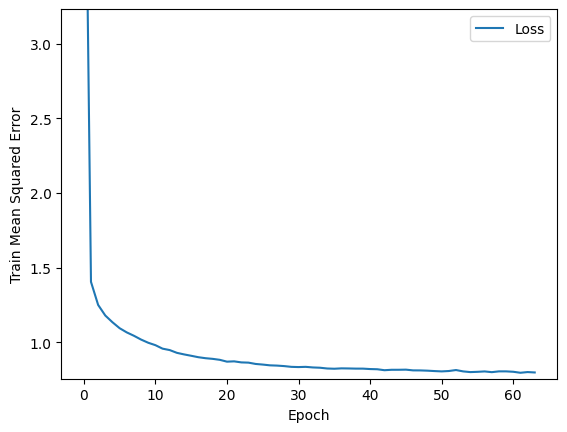

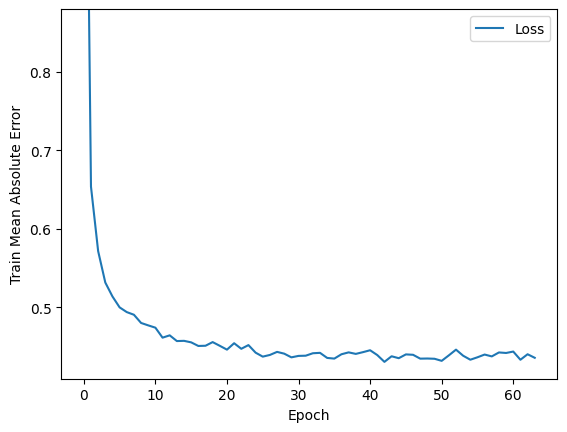

'Evaluating the model against the test_df'

75/75 [==============================] - 0s 532us/step - loss: 1.0075 - mean_squared_error: 0.8610 - mean_absolute_error: 0.5514


'Predicting the nn_origin_df and comparing with the initial data'

123403/123403 [==============================] - 47s 380us/step


'predictions'

array([1.2947615, 1.2947615, 1.2947615, ..., 1.2947615, 1.2947617,
       1.2947617], dtype=float32)

'predictions.shape'

(15795488,)

'real_ratings'

array([0., 0., 0., ..., 0., 0., 0.])

'real_mean_squared_error=0.5535912206736205, real_mean_absolute_error=0.6490496521998214'

'Dataframe with filter user ratings (non zero) and neighbors ratings scaled by maximum rating'

,USER_INDEX,MOVIE_INDEX,USER_RATINGS,NEIGHBOR_RATINGS_0,NEIGHBOR_RATINGS_1,NEIGHBOR_RATINGS_2,NEIGHBOR_RATINGS_3,NEIGHBOR_RATINGS_4,NEIGHBOR_RATINGS_5
2311,0,2311,8.0,8.0,0.0,10.0,0.0,0.0,0.0
2532,0,2532,9.0,9.0,0.0,0.0,0.0,0.0,0.0
2756,0,2756,8.0,8.0,0.0,0.0,0.0,0.0,0.0
2947,0,2947,8.0,8.0,0.0,0.0,0.0,0.0,0.0
3222,0,3222,10.0,10.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...
6671765,97,67617,6.0,0.0,6.0,0.0,0.0,0.0,0.0
6671817,97,67669,6.0,0.0,6.0,0.0,0.0,0.0,0.0
6671909,97,67761,8.0,0.0,8.0,0.0,0.0,0.0,0.0
6672032,97,67884,8.0,0.0,8.0,0.0,0.0,0.0,0.0


,USER_INDEX,MOVIE_INDEX,USER_RATINGS,NEIGHBOR_RATINGS_0,NEIGHBOR_RATINGS_1,NEIGHBOR_RATINGS_2,NEIGHBOR_RATINGS_3,NEIGHBOR_RATINGS_4,NEIGHBOR_RATINGS_5
count,21669.000000,21669.000000,21669.000000,21669.000000,21669.000000,21669.000000,21669.000000,21669.000000,21669.000000
mean,47.677327,23463.599658,7.345286,4.116249,3.393650,2.620979,2.677235,2.159721,1.684157
std,28.582779,12872.434720,2.238343,4.027298,4.090201,3.835758,3.884671,3.643206,3.330305
min,0.000000,7.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,22.000000,14657.000000,6.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,47.000000,20299.000000,8.000000,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,73.000000,29296.000000,9.000000,8.000000,8.000000,7.000000,7.000000,5.000000,0.000000
max,97.000000,67968.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000


'train_df'

,USER_INDEX,MOVIE_INDEX,USER_RATINGS,NEIGHBOR_RATINGS_0,NEIGHBOR_RATINGS_1,NEIGHBOR_RATINGS_2,NEIGHBOR_RATINGS_3,NEIGHBOR_RATINGS_4,NEIGHBOR_RATINGS_5
2268372,33,21600,8.0,8.0,0.0,0.0,0.0,8.0,0.0
4236742,62,15534,10.0,0.0,10.0,0.0,6.0,0.0,0.0
775260,11,26336,10.0,0.0,0.0,0.0,10.0,0.0,0.0
6128667,90,1107,5.0,5.0,0.0,0.0,0.0,0.0,0.0
1723512,25,21412,10.0,5.0,8.0,7.0,8.0,8.0,10.0
...,...,...,...,...,...,...,...,...,...
3623278,53,14826,1.0,0.0,1.0,1.0,0.0,0.0,0.0
6643653,97,39505,10.0,0.0,10.0,0.0,0.0,0.0,0.0
1527292,22,29444,8.0,9.0,8.0,7.0,9.0,0.0,5.0
224057,3,19805,8.0,0.0,8.0,0.0,0.0,7.0,7.0


'test_df'

,USER_INDEX,MOVIE_INDEX,USER_RATINGS,NEIGHBOR_RATINGS_0,NEIGHBOR_RATINGS_1,NEIGHBOR_RATINGS_2,NEIGHBOR_RATINGS_3,NEIGHBOR_RATINGS_4,NEIGHBOR_RATINGS_5
763049,11,14125,2.0,0.0,0.0,0.0,2.0,0.0,0.0
2996833,44,1137,6.0,6.0,0.0,0.0,0.0,0.0,0.0
4054819,59,37863,7.0,0.0,0.0,0.0,0.0,7.0,0.0
2127341,31,16737,5.0,0.0,5.0,5.0,10.0,0.0,0.0
4914339,72,12291,7.0,0.0,7.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...
1519908,22,22060,9.0,0.0,9.0,0.0,0.0,0.0,0.0
4649456,68,19744,6.0,0.0,6.0,0.0,0.0,0.0,5.0
5129374,75,23074,10.0,8.0,10.0,8.0,10.0,9.0,8.0
3618184,53,9732,9.0,0.0,9.0,0.0,0.0,0.0,0.0


'Training the model with the train_df'

Epoch 1/64
136/136 [==============================] - 1s 609us/step - loss: 20.3877 - mean_squared_error: 19.8762 - mean_absolute_error: 3.4471
Epoch 2/64
136/136 [==============================] - 0s 584us/step - loss: 2.8212 - mean_squared_error: 2.3355 - mean_absolute_error: 1.0629
Epoch 3/64
136/136 [==============================] - 0s 596us/step - loss: 2.1146 - mean_squared_error: 1.6454 - mean_absolute_error: 0.8421
Epoch 4/64
136/136 [==============================] - 0s 588us/step - loss: 1.8528 - mean_squared_error: 1.3935 - mean_absolute_error: 0.7378
Epoch 5/64
136/136 [==============================] - 0s 582us/step - loss: 1.7271 - mean_squared_error: 1.2789 - mean_absolute_error: 0.6807
Epoch 6/64
136/136 [==============================] - 0s 589us/step - loss: 1.6389 - mean_squared_error: 1.2033 - mean_absolute_error: 0.6324
Epoch 7/64
136/136 [==============================] - 0s 602us/step - loss: 1.5656 - mean_squared_error: 1.1413 - mean_absolute_error: 0.5940
Epoc

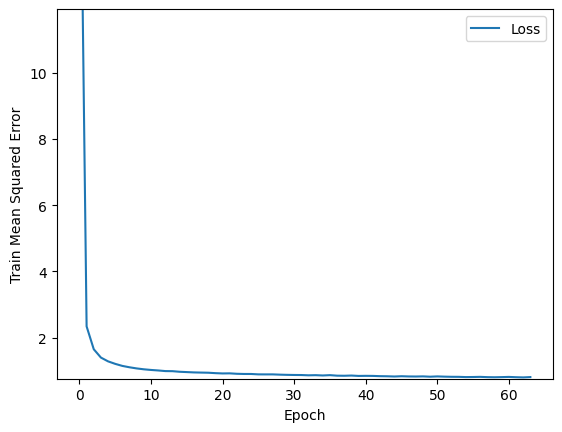

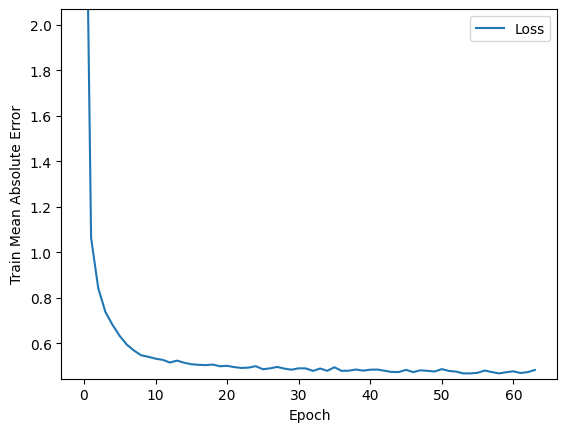

'Evaluating the model against the test_df'

34/34 [==============================] - 0s 547us/step - loss: 1.0907 - mean_squared_error: 0.9018 - mean_absolute_error: 0.5079


'Predicting the nn_origin_df and comparing with the initial data'

52127/52127 [==============================] - 20s 392us/step


'predictions'

array([0.78799975, 0.78799975, 0.78799975, ..., 0.78799975, 0.78799975,
       0.78799975], dtype=float32)

'predictions.shape'

(6672232,)

'real_ratings'

array([0., 0., 0., ..., 0., 0., 0.])

'real_mean_squared_error=0.4849819168314352, real_mean_absolute_error=0.5700883450116847'

'Dataframe with filter user ratings (non zero) and neighbors ratings scaled by maximum rating'

,USER_INDEX,MOVIE_INDEX,USER_RATINGS,NEIGHBOR_RATINGS_0,NEIGHBOR_RATINGS_1,NEIGHBOR_RATINGS_2,NEIGHBOR_RATINGS_3,NEIGHBOR_RATINGS_4,NEIGHBOR_RATINGS_5
27825,0,27825,5.0,5.0,0.0,0.0,0.0,0.0,0.0
28744,0,28744,5.0,5.0,8.0,0.0,0.0,8.0,7.0
38395,0,38395,6.0,6.0,0.0,0.0,6.0,8.0,0.0
40242,0,40242,4.0,4.0,8.0,9.0,0.0,0.0,0.0
40398,0,40398,4.0,4.0,8.0,0.0,7.0,9.0,0.0
...,...,...,...,...,...,...,...,...,...
7349158,107,64170,6.0,0.0,6.0,6.0,0.0,6.0,0.0
7350078,107,65090,4.0,0.0,0.0,4.0,0.0,0.0,0.0
7350154,107,65166,8.0,0.0,0.0,8.0,0.0,0.0,0.0
7350361,107,65373,8.0,0.0,0.0,8.0,9.0,0.0,0.0


,USER_INDEX,MOVIE_INDEX,USER_RATINGS,NEIGHBOR_RATINGS_0,NEIGHBOR_RATINGS_1,NEIGHBOR_RATINGS_2,NEIGHBOR_RATINGS_3,NEIGHBOR_RATINGS_4,NEIGHBOR_RATINGS_5
count,23027.000000,23027.000000,23027.000000,23027.000000,23027.000000,23027.000000,23027.000000,23027.000000,23027.000000
mean,53.374387,49581.686194,6.522734,3.620446,3.008772,2.494767,2.045816,2.021236,1.766231
std,31.452982,15205.534326,2.302239,3.732143,3.585345,3.538365,3.327075,3.360583,3.211883
min,0.000000,7.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,25.000000,44277.000000,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,53.000000,54697.000000,7.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,81.000000,60620.000000,8.000000,7.000000,7.000000,6.000000,5.000000,5.000000,0.000000
max,107.000000,68055.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000


'train_df'

,USER_INDEX,MOVIE_INDEX,USER_RATINGS,NEIGHBOR_RATINGS_0,NEIGHBOR_RATINGS_1,NEIGHBOR_RATINGS_2,NEIGHBOR_RATINGS_3,NEIGHBOR_RATINGS_4,NEIGHBOR_RATINGS_5
2377562,34,62706,3.0,3.0,0.0,0.0,3.0,0.0,0.0
2718029,39,62753,9.0,6.0,9.0,6.0,4.0,7.0,0.0
4852010,71,18046,8.0,0.0,8.0,0.0,0.0,0.0,0.0
4341029,63,51737,6.0,6.0,5.0,0.0,7.0,0.0,0.0
2299523,33,52751,7.0,7.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...
3805290,55,60670,5.0,0.0,0.0,5.0,0.0,0.0,0.0
6932706,101,56222,9.0,7.0,4.0,9.0,0.0,0.0,5.0
1689012,24,54996,4.0,4.0,0.0,0.0,0.0,0.0,0.0
292929,4,20593,7.0,0.0,7.0,0.0,0.0,0.0,0.0


'test_df'

,USER_INDEX,MOVIE_INDEX,USER_RATINGS,NEIGHBOR_RATINGS_0,NEIGHBOR_RATINGS_1,NEIGHBOR_RATINGS_2,NEIGHBOR_RATINGS_3,NEIGHBOR_RATINGS_4,NEIGHBOR_RATINGS_5
2209033,32,30345,8.0,0.0,8.0,0.0,0.0,0.0,0.0
3046894,44,51198,2.0,7.0,0.0,8.0,2.0,0.0,0.0
3008744,44,13048,10.0,0.0,0.0,0.0,10.0,0.0,8.0
2103626,30,61106,5.0,0.0,5.0,0.0,0.0,0.0,0.0
1886207,27,47939,8.0,0.0,8.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...
150734,2,14566,10.0,0.0,0.0,0.0,0.0,10.0,0.0
4695219,68,65507,3.0,0.0,0.0,0.0,0.0,3.0,0.0
672898,9,60142,4.0,0.0,4.0,3.0,2.0,0.0,2.0
6859863,100,51463,6.0,6.0,4.0,7.0,6.0,7.0,0.0


'Training the model with the train_df'

Epoch 1/64
144/144 [==============================] - 1s 618us/step - loss: 9.7008 - mean_squared_error: 9.1873 - mean_absolute_error: 2.2089
Epoch 2/64
144/144 [==============================] - 0s 581us/step - loss: 2.5138 - mean_squared_error: 2.0425 - mean_absolute_error: 0.9548
Epoch 3/64
144/144 [==============================] - 0s 582us/step - loss: 2.1251 - mean_squared_error: 1.6717 - mean_absolute_error: 0.8265
Epoch 4/64
144/144 [==============================] - 0s 579us/step - loss: 1.9153 - mean_squared_error: 1.4729 - mean_absolute_error: 0.7437
Epoch 5/64
144/144 [==============================] - 0s 583us/step - loss: 1.7937 - mean_squared_error: 1.3618 - mean_absolute_error: 0.6813
Epoch 6/64
144/144 [==============================] - 0s 584us/step - loss: 1.7194 - mean_squared_error: 1.2998 - mean_absolute_error: 0.6394
Epoch 7/64
144/144 [==============================] - 0s 588us/step - loss: 1.6650 - mean_squared_error: 1.2577 - mean_absolute_error: 0.6127
Epoch 

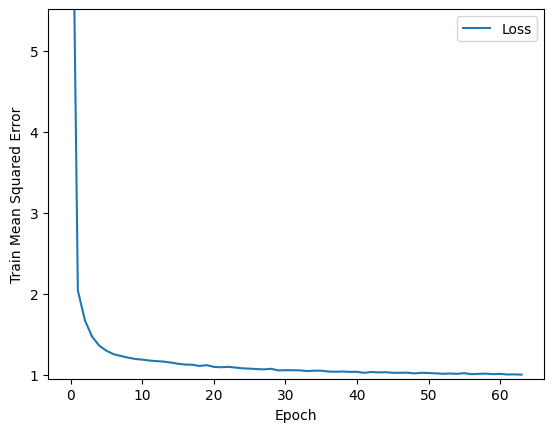

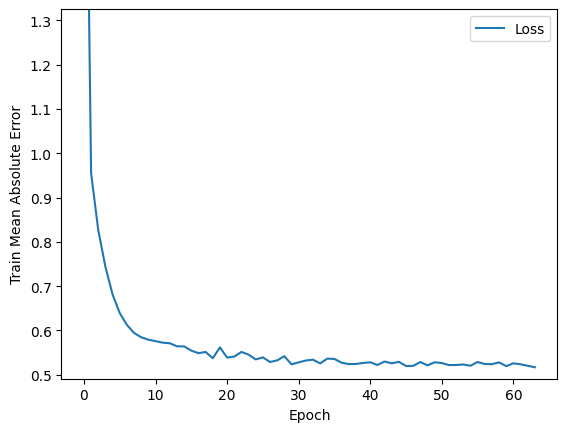

'Evaluating the model against the test_df'

36/36 [==============================] - 0s 548us/step - loss: 1.2377 - mean_squared_error: 1.0615 - mean_absolute_error: 0.5276


'Predicting the nn_origin_df and comparing with the initial data'

57446/57446 [==============================] - 22s 376us/step


'predictions'

array([0.86267453, 0.86267453, 0.86267453, ..., 0.86267453, 0.86267453,
       0.86267453], dtype=float32)

'predictions.shape'

(7353072,)

'real_ratings'

array([0., 0., 0., ..., 0., 0., 0.])

'real_mean_squared_error=0.5263864969821015, real_mean_absolute_error=0.575409953572005'

'results_df'

,TRAIN_MSE,TRAIN_MAE,TEST_MSE,TEST_MAE,REAL_MSE,REAL_MAE
CLUSTER_0,0.781631,0.485587,0.824947,0.478807,0.473108,0.525478
CLUSTER_1,0.484070,0.296895,0.513278,0.312168,0.321919,0.440657
CLUSTER_2,0.798787,0.435371,0.860975,0.551389,0.553591,0.649050
CLUSTER_3,0.803893,0.483120,0.901815,0.507938,0.484982,0.570088
CLUSTER_4,1.005727,0.517016,1.061539,0.527639,0.526386,0.575410


In [31]:
# Define functions to create and train a linear regression model

def create_nn_filtered_normalized_df(nn_origin_df: pd.DataFrame, NEIGHBOURS_COLUMNS: list[str], ratings_normalize_factor: float):
    # filter the rows that have USER_RATINGS == 0
    nn_filtered_df = nn_origin_df.copy()[nn_origin_df['USER_RATINGS'] != 0]

    # filter the rows that have all NEIGHBOR_RATINGS == 0
    filter_neighbors_query: str = f'{NEIGHBOURS_COLUMNS[0]} != 0'
    for neihbor_column in NEIGHBOURS_COLUMNS[1:]:
        filter_neighbors_query += f' | {neihbor_column} != 0'

    nn_filtered_df = nn_filtered_df.query(filter_neighbors_query)

    # create filtered normalized df
    nn_filtered_normalized_df = nn_filtered_df.copy()
    columns_to_normalize = ['USER_RATINGS']
    columns_to_normalize.extend(NEIGHBOURS_COLUMNS)
    nn_filtered_normalized_df[columns_to_normalize] = nn_filtered_normalized_df[columns_to_normalize] / ratings_normalize_factor
    display('Dataframe with filter user ratings (non zero) and neighbors ratings scaled by maximum rating')
    display(nn_filtered_normalized_df)
    display(nn_filtered_normalized_df.describe())
    return nn_filtered_df, nn_filtered_normalized_df


def create_model(my_learning_rate: float, input_shape: tuple):
    """Create and compile a simple linear regression model."""
    # Most simple tf.keras models are sequential.
    model = tf.keras.models.Sequential()

    
    # Add the layer containing the feature columns to the model.
    model.add(tf.keras.layers.InputLayer(input_shape=input_shape))

    model.add(tf.keras.layers.Masking(
        mask_value=0
    ))

    # Implement L2 regularization in the first hidden layer.
    model.add(tf.keras.layers.Dense(units=12, 
                                    activation='relu',
                                    kernel_regularizer=tf.keras.regularizers.l2(0.01),
                                    name='Hidden1'))
    
    # Implement L2 regularization in the second hidden layer.
    model.add(tf.keras.layers.Dense(units=24, 
                                    activation='relu', 
                                    kernel_regularizer=tf.keras.regularizers.l2(0.01),
                                    name='Hidden2'))
    
    # Implement L2 regularization in the third hidden layer.
    model.add(tf.keras.layers.Dense(units=48,
                                    activation='relu', 
                                    kernel_regularizer=tf.keras.regularizers.l2(0.01),
                                    name='Hidden3'))

    # Define the output layer.
    model.add(tf.keras.layers.Dense(units=1,  
                                    name='Output'))                              
    
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=my_learning_rate),
                    loss="mean_squared_error",
                    metrics=[tf.keras.metrics.MeanSquaredError(), tf.keras.metrics.MeanAbsoluteError()])
    return model           


def train_model(model: tf.keras.models.Sequential, X_train: np_typing.NDArray, Y_train: np_typing.NDArray, epochs: int, batch_size: int=1):
    """Train the model by feeding it X_train."""

    # Features as a numpy array
    history = model.fit(x=X_train, y=Y_train, batch_size=batch_size, epochs=epochs, shuffle=True) 

    # The list of epochs is stored separately from the rest of history.
    epochs = history.epoch
    
    # To track the progression of training, gather a snapshot
    # of the model's mean squared error at each epoch. 
    hist = pd.DataFrame(history.history)
    mse = hist["mean_squared_error"]
    mae = hist["mean_absolute_error"]

    return epochs, mse, mae


def evaluate_model(model: tf.keras.models.Sequential, X_test: np_typing.NDArray, Y_test: np_typing.NDArray, batch_size: int=1):
    """Evaluate the model against the X_test"""

    # Features as a numpy array
    return model.evaluate(x = X_test, y = Y_test, batch_size=batch_size)


def predict_model(model: tf.keras.models.Sequential, X_origin: np_typing.NDArray, batch_size: int=1):
    """Evaluate the model with the X_origin"""

    # Features as a numpy array
    return model.predict(x = X_origin, batch_size=batch_size)


def plot_the_loss_curve(epochs, mse_or_mae, is_mse: bool, filename: str):
    """Plot a curve of loss vs. epoch."""

    plt.figure()
    plt.xlabel("Epoch")
    ylabel = 'Train Mean Squared Error' if is_mse else 'Train Mean Absolute Error'
    plt.ylabel(ylabel)

    plt.plot(epochs, mse_or_mae, label="Loss")
    plt.legend()
    plt.ylim([mse_or_mae.min()*0.95, mse_or_mae.max() * 0.6])
    plt.savefig(os.path.join(RESULTS_PATH, filename))
    plt.show()



def calculate_real_mse_mae(origin_ratings: np_typing.NDArray, predictions: np_typing.NDArray):
    """Calculate the real mse and mae comparing real ratings and predictions."""

    n = 0
    absolute_sum = 0
    squared_sum = 0
    for i in range(origin_ratings.shape[0]):
        # take into consideration only non 0 ratings
        if origin_ratings[i] != 0.0:
            n += 1
            abs_value = abs(origin_ratings[i] - predictions[i])
            absolute_sum += abs_value
            squared_sum += math.sqrt(abs_value)

    
    mse = absolute_sum / n
    mae = squared_sum / n
    return mse, mae


def create_train_evaluate_neural_network(ratings_normalize_factor, nn_origin_df: pd.DataFrame, nn_filtered_normalized_df: pd.DataFrame, NEIGHBOURS_COLUMNS: list[str], cluster_index: int) -> tuple[float, float, float, float, float, float]:
    train_df, test_df = train_test_split(nn_filtered_normalized_df, test_size=0.2, random_state=42)
    train_df = pd.DataFrame(train_df)
    test_df = pd.DataFrame(test_df)

    display('train_df', train_df)
    display('test_df', test_df)

    # The following variables are the hyperparameters.
    learning_rate = 0.001
    epochs = 64
    batch_size = 128

    # define the feature columns
    # Establish the model's topography.
    X_train = train_df[NEIGHBOURS_COLUMNS].to_numpy()
    Y_train = train_df['USER_RATINGS'].to_numpy()
    input_shape = (X_train.shape[1],)
    my_model = create_model(learning_rate, input_shape)

    # Train the model on the normalized training set.
    display('Training the model with the train_df')
    epochs, train_mse_series, train_mae_series = train_model(my_model, X_train, Y_train, epochs, batch_size)
    train_mse = train_mse_series.iloc[-1]
    train_mae = train_mae_series.iloc[-1]
    plot_the_loss_curve(epochs, train_mse_series, True, f'cluster{cluster_index}_mse.png')
    plot_the_loss_curve(epochs, train_mae_series, False, f'cluster{cluster_index}_mae.png')

    display('Evaluating the model against the test_df')
    X_test = test_df[NEIGHBOURS_COLUMNS].to_numpy()
    Y_test = test_df['USER_RATINGS'].to_numpy()
    test_loss, test_mse, test_mae = evaluate_model(my_model, X_test, Y_test, batch_size)

    display('Predicting the nn_origin_df and comparing with the initial data')
    X_origin = nn_origin_df[NEIGHBOURS_COLUMNS].to_numpy()
    predictions_normalized = predict_model(my_model, X_origin, batch_size)
    # turn list of sinle item lists to a sigle list with floats
    predictions_normalized = np.array([prediction_normalized[0] for prediction_normalized in predictions_normalized])
    predictions = predictions_normalized * ratings_normalize_factor
    display('predictions', predictions)
    display('predictions.shape', predictions.shape)

    real_ratings = nn_origin_df['USER_RATINGS'].to_numpy()


    # Save csv results
    # nn_filtered_normalized_df_csv = os.path.join(RESULTS_PATH, F"cluster{cluster_index}_nn_filtered_normalized.csv")
    # nn_filtered_normalized_df.to_csv(nn_filtered_normalized_df_csv, encoding='utf-8')

    real_ratings_predictions_df = nn_origin_df.copy()
    real_ratings_predictions_df['USER_RATINGS'] = real_ratings
    real_ratings_predictions_df.insert(2, 'PREDICTIONS', predictions)
    real_ratings_predictions_df = real_ratings_predictions_df.sort_values(by=['USER_INDEX', 'PREDICTIONS'], ascending=[True, False])
    # real_ratings_predictions_df['PREDICTIONS'] = predictions
    real_ratings_predictions_df_csv = os.path.join(RESULTS_PATH, F"cluster{cluster_index}_real_ratings_predictions.csv")
    real_ratings_predictions_df.to_csv(real_ratings_predictions_df_csv)

    display('real_ratings', real_ratings)
    real_mse, real_mae = calculate_real_mse_mae(real_ratings, predictions_normalized)
    display(f'real_mean_squared_error={real_mse}, real_mean_absolute_error={real_mae}')

    return train_mse, train_mae, test_mse, test_mae, real_mse, real_mae


# THANOS NEURAL NETWORK
display('ratings_normalize_factor', ratings_normalize_factor)

# Create, train and evaluate a Neural Network for each cluster

results: list[list[float]] = []
results_df_index: list[str] = []

for cluster_index in range(len(clusters_ratings)):
    cluster_ratings = clusters_ratings[cluster_index]
    nearest_neighbors = clusters_nearest_neighbors[cluster_index]    

    pickle_file = os.path.join(DATAFOLDER_PATH, f"L_K_DEPEND_clusters_nn_original_dfs_{cluster_index}.pkl")
    nn_origin_df = pd.read_pickle(pickle_file)
    nn_filtered_df, nn_filtered_normalized_df = create_nn_filtered_normalized_df(nn_origin_df, NEIGHBOURS_COLUMNS, ratings_normalize_factor)

    train_mse, train_mae, test_mse, test_mae, real_mse, real_mae = create_train_evaluate_neural_network(
        ratings_normalize_factor, nn_origin_df, nn_filtered_normalized_df, NEIGHBOURS_COLUMNS, cluster_index)
    results.append([train_mse, train_mae, test_mse,
                   test_mae, real_mse, real_mae])
    results_df_index.append(f'CLUSTER_{cluster_index}')
    # Clear memory
    cluster_ratings = nearest_neighbors = pickle_file = nn_origin_df = nn_filtered_df = nn_filtered_normalized_df = None


results_df_columns = ['TRAIN_MSE', 'TRAIN_MAE',
                      'TEST_MSE', 'TEST_MAE', 'REAL_MSE', 'REAL_MAE']
results_df = pd.DataFrame(
    results, columns=results_df_columns, index=results_df_index)
display('results_df', results_df)

results_df_csv = os.path.join(RESULTS_PATH, F"results.csv")
results_df.to_csv(results_df_csv, encoding='utf-8')
